In [3]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import torch

import awkward as ak
import fastjet
import vector

from copy import deepcopy

In [4]:
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import argparse
import awkward as ak
import numpy as np
import pandas as pd
import vector
import mplhep as hep
import torch
import os
import os.path as osp

# Examine saved dataset

In [3]:
import h5py
import json
save_path = "../data/val"
with h5py.File(f'{save_path}/val_20_30.h5', 'r') as hdf:
        # Access the dataset containing your JSON strings
    dataset = hdf["subjets"]
    
    # Initialize a list to hold the deserialized subjets data
    subjets_data = []
    particles_features = hdf["particles"]["features"][:]
    particles_labels = hdf["particles"]["labels"][:]
    
    # Iterate over each JSON string in the dataset
    for json_str in dataset:
        # Deserialize the JSON string to a Python object
        subjet = json.loads(json_str)
        subjets_data.append(subjet)

# At this point, `subjets_data` contains all your subjets as Python dictionaries

### ~400k jets in total  
### Each jet contains 128 particles (some are zero-padded)  
### Each particle has 4 features: part_deta, part_dphi, part_pt_log, part_e_log

In [4]:
particles_features.shape

(403000, 4, 128)

In [6]:
particles_labels.shape

(403000,)

In [5]:
len(subjets_data)

403000

### Each jet is clustered into 20 different subjets (zero-padded if not enough subjets)  

In [7]:
len(subjets_data[0])

20

### Each subjet is a dictionary

In [13]:
type(subjets_data[0][0])

dict

In [14]:
subjets_data[0][0].keys()

dict_keys(['features', 'indices'])

### 'features' contains subjet level information ($p_T, \eta, \phi$ of the subjet, and number of particles)

In [12]:
subjets_data[0][0]['features']

{'pT': 563.1187802221922,
 'eta': 0.4276622300992181,
 'phi': 5.0734595349950595,
 'num_ptcls': 15}

### 'indices' are the indices of the particles contained in the subjet
### Each subjet contains 30 particles (zero-padded if not enough particles) ordered by $p_T$  
-1 indicates zero-padded particles

In [10]:
len(subjets_data[0][0]['indices'])

30

In [15]:
subjets_data[0][0]['indices']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

### We can use the indices to get the particle level features

In [42]:
subjet_0_0_particles = particles_features[0, :, subjets_data[0][0]['indices']]
print(f"shape: {subjet_0_0_particles.shape}")
print(f"0th element: {subjet_0_0_particles[0]}")

shape: (30, 4)
0th element: [ 8.07034969e-03 -2.84028053e-03  5.49364185e+00  5.58603764e+00]


# Code used to generate the dataset

In [5]:
"""Runs data processing scripts to turn raw data from (../raw) into
cleaned data ready to be analyzed (saved in ../processed).
Convert h5 to pt files, each containing 100k zero-padded jets cropped to 50 constituents
Shape: (100k, 3, 50)
"""
logger = logging.getLogger(__name__)
logger.info("making final data set from raw data")
label = "val"
hdf5_file = f"/ssl-jet-vol-v3/toptagging/{label}/raw/{label}.h5"
vector.register_awkward()

print("reading h5 file")
df = pd.read_hdf(hdf5_file, key="table")
print("finished reading h5 file")

reading h5 file
finished reading h5 file


In [6]:
def zero_pad_jets(arr, max_nconstit=128):
    """
    arr: numpy array
    """
    arr = arr[:max_nconstit]
    if arr.shape[0] < max_nconstit:
        zeros = np.zeros([max_nconstit - arr.shape[0],1])
        padded_arr = np.concatenate((arr, zeros), axis=0)
        return padded_arr
    else:
        return arr

## Obtain (pT, eta_rel, phi_rel, E)

In [7]:
def _col_list(prefix, max_particles=200):
    return ["%s_%d" % (prefix, i) for i in range(max_particles)]

_px = df[_col_list("PX")].values
_py = df[_col_list("PY")].values
_pz = df[_col_list("PZ")].values
_e = df[_col_list("E")].values

mask = _e > 0
n_particles = np.sum(mask, axis=1)

px = ak.unflatten(_px[mask], n_particles)
py = ak.unflatten(_py[mask], n_particles)
pz = ak.unflatten(_pz[mask], n_particles)
energy = ak.unflatten(_e[mask], n_particles)

p4 = ak.zip(
    {
        "px": px,
        "py": py,
        "pz": pz,
        "energy": energy,
    },
    with_name="Momentum4D",
)

jet_p4 = ak.sum(p4, axis=-1)

In [8]:
import tqdm
# outputs
v = {}
v["label"] = df["is_signal_new"].values

v["jet_pt"] = jet_p4.pt.to_numpy()
v["jet_eta"] = jet_p4.eta.to_numpy()
v["jet_phi"] = jet_p4.phi.to_numpy()
v["jet_energy"] = jet_p4.energy.to_numpy()
v["jet_mass"] = jet_p4.mass.to_numpy()
v["jet_nparticles"] = n_particles

v["part_px"] = px
v["part_py"] = py
v["part_pz"] = pz
v["part_energy"] = energy

# dim 1 ordering: 'part_deta','part_dphi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
v["part_deta"] = p4.eta - v["jet_eta"]
v["part_dphi"] = p4.phi - v["jet_phi"]
v["part_pt"] = np.hypot(v["part_px"], v["part_py"])
v["part_pt_log"] = np.log(v["part_pt"])
v["part_e_log"] = np.log(v["part_energy"])

In [9]:
features = []
labels = []

for jet_index in tqdm.tqdm(range(len(df))):
    # dim 1 ordering: 'part_eta','part_phi','part_pt_log', 'part_e_log', 'part_logptrel', 'part_logerel','part_deltaR'
    part_deta = zero_pad_jets(
        v["part_deta"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_dphi = zero_pad_jets(
        v["part_dphi"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_pt_log = zero_pad_jets(
        v["part_pt_log"][jet_index].to_numpy().reshape(-1, 1)
    )
    part_e_log = zero_pad_jets(
        v["part_e_log"][jet_index].to_numpy().reshape(-1, 1)
    )
    
    jet = np.concatenate([part_deta, part_dphi, part_pt_log, part_e_log], axis=1).transpose()
    y = v["label"][jet_index]

    features.append(jet)
    labels.append(y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403000/403000 [01:40<00:00, 3996.35it/s]


In [10]:
features_array = np.stack(features)
labels_array = np.stack(labels)
features_array.shape

(403000, 4, 128)

In [11]:
labels_array.shape

(403000,)

## determine the number of subjets and number of particles per subjet

In [12]:
save_path = "../plots/jet_split"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

In [13]:
def get_subjets(px, py, pz, e, JET_ALGO="CA", jet_radius=0.2):
    """
    take the particles and cluster them into however many jets there are of a given smaller radius (say R=0.2)

    Args:
        px [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the px of each particle inside the jet
        py [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the py of each particle inside the jet
        pz [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the pz of each particle inside the jet
        e [np.ndarray]: NumPy array of shape ``[num_particles]`` containing the e of each particle inside the jet
        JET_ALGO [str]: The jet declustering algorithm to use. Choices are ["CA", "kt", "antikt"]
            (default is "CA")
        jet_radius [float]: The jet radius to use when declustering
            (default is 0.8)

    Returns:
        subjet_idx [np.array]: NumPy array of shape ``[num_particles]`` with elements
                                representing which subjet the particle belongs to
        subjet_vectors [list]: includes bjet information (e.g. px, py, pz)
    """


    if JET_ALGO == "kt":
        JET_ALGO = fastjet.kt_algorithm
    elif JET_ALGO == "antikt":
        JET_ALGO = fastjet.antikt_algorithm
    elif JET_ALGO == "CA":
        JET_ALGO = fastjet.cambridge_algorithm

    jetdef = fastjet.JetDefinition(JET_ALGO, jet_radius)

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
        },
        with_name="MomentumArray4D",
    )

    pseudojet = [
        fastjet.PseudoJet(particle.px.item(), particle.py.item(), particle.pz.item(), particle.E.item()) for particle in jet
    ]

    cluster = fastjet.ClusterSequence(pseudojet, jetdef)

    return cluster

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

jet_radius = 0.2
# Assuming _px, _py, _pz, _e are your jet component arrays and get_subjets is your function to get subjets

# Sample 10% of the data randomly
sample_size = int(0.1 * len(df))  # Calculate 10% of your dataset size
sampled_indices = random.sample(range(len(df)), sample_size)  # Get random indices

# Lists to hold the data for histograms
num_subjets_per_jet = []
num_constituents_per_subjet = []

for jet_idx in tqdm.tqdm(sampled_indices):  # Iterate over sampled indices
    # print(f"non zero constituents of jet {jet_idx}: {np.count_nonzero(_px[jet_idx])}")
    cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0], _py[jet_idx][_py[jet_idx] != 0], _pz[jet_idx][_pz[jet_idx] != 0], _e[jet_idx][_e[jet_idx] != 0], JET_ALGO="CA", , jet_radius=jet_radius)
    jets = cluster.inclusive_jets()
    num_subjets_per_jet.append(len(jets))  # Track the number of subjets per jet
    for i, jet in enumerate(jets):
        constituents = jet.constituents()
        # print(f"Jet {i} has {len(constituents)} constituents.")
        num_constituents_per_subjet.append(len(constituents))  # Track the number of constituents per subjet

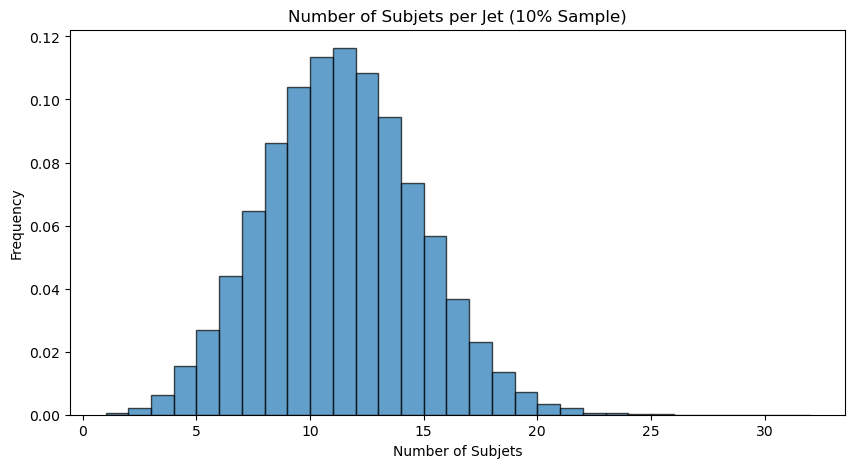

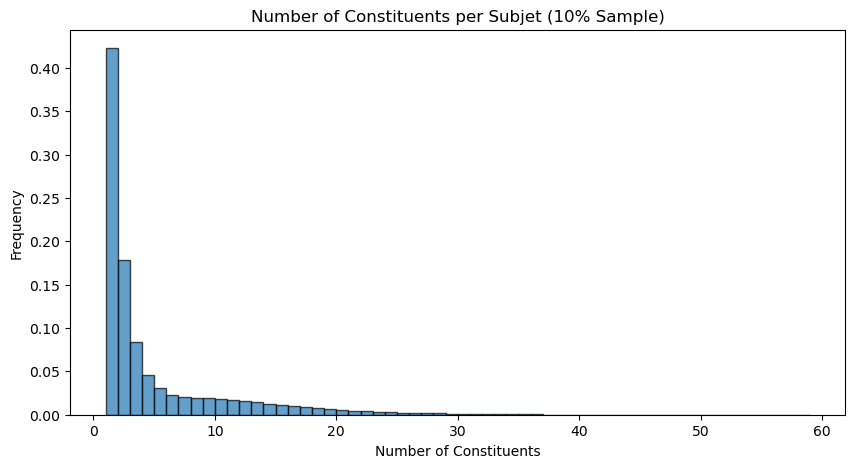

In [27]:
# Plotting the histogram for the number of subjets per jet
plt.figure(figsize=(10, 5))
plt.hist(num_subjets_per_jet, bins=range(min(num_subjets_per_jet), max(num_subjets_per_jet) + 2), alpha=0.7, density=True, edgecolor='black')
plt.title('Number of Subjets per Jet (10% Sample)')
plt.xlabel('Number of Subjets')
plt.ylabel('Frequency')
plt.show()

# Plotting the histogram for the number of constituents per subjet
plt.figure(figsize=(10, 5))
plt.hist(num_constituents_per_subjet, bins=range(min(num_constituents_per_subjet), max(num_constituents_per_subjet) + 2), alpha=0.7, density=True, edgecolor='black')
plt.title('Number of Constituents per Subjet (10% Sample)')
plt.xlabel('Number of Constituents')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

# Assuming get_subjets is your function to get subjets with an algorithm parameter
jet_radius = 0.2
algorithms = ["CA", "kt", "antikt"]
colors = ['r', 'g', 'b']  # Colors for the histograms
sample_size = int(0.1 * len(df))  # Calculate 10% of your dataset size
sampled_indices = random.sample(range(len(df)), sample_size)  # Get random indices

# Prepare to collect histogram data for each algorithm
num_subjets_per_jet_data = {alg: [] for alg in algorithms}
num_constituents_per_subjet_data = {alg: [] for alg in algorithms}

for alg in algorithms:
    print(alg)
    for jet_idx in tqdm.tqdm(sampled_indices, desc=f"Processing with {alg}"):
        cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0], _py[jet_idx][_py[jet_idx] != 0], _pz[jet_idx][_pz[jet_idx] != 0], _e[jet_idx][_e[jet_idx] != 0], JET_ALGO=alg, jet_radius=jet_radius)
        jets = cluster.inclusive_jets()
        num_subjets_per_jet_data[alg].append(len(jets))
        for jet in jets:
            constituents = jet.constituents()
            num_constituents_per_subjet_data[alg].append(len(constituents))

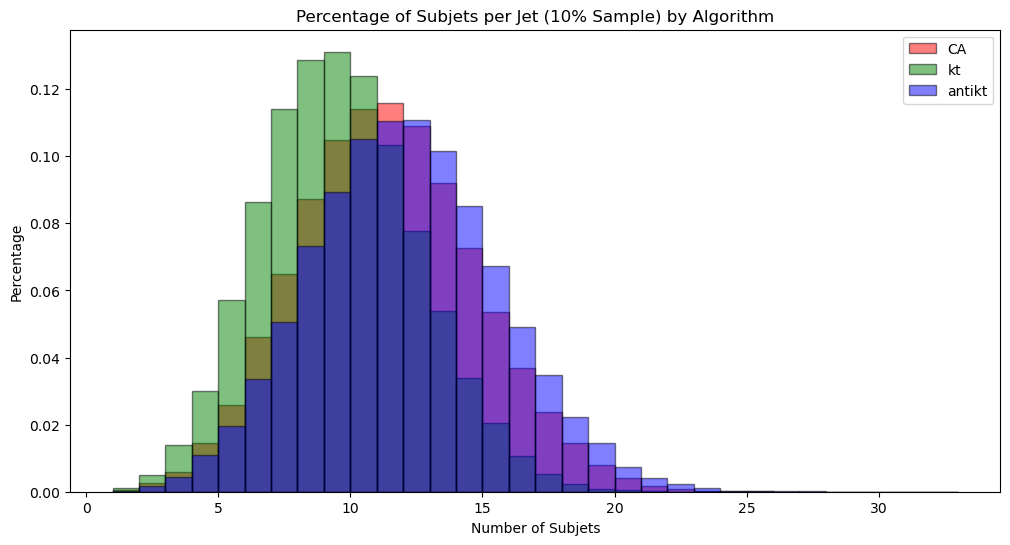

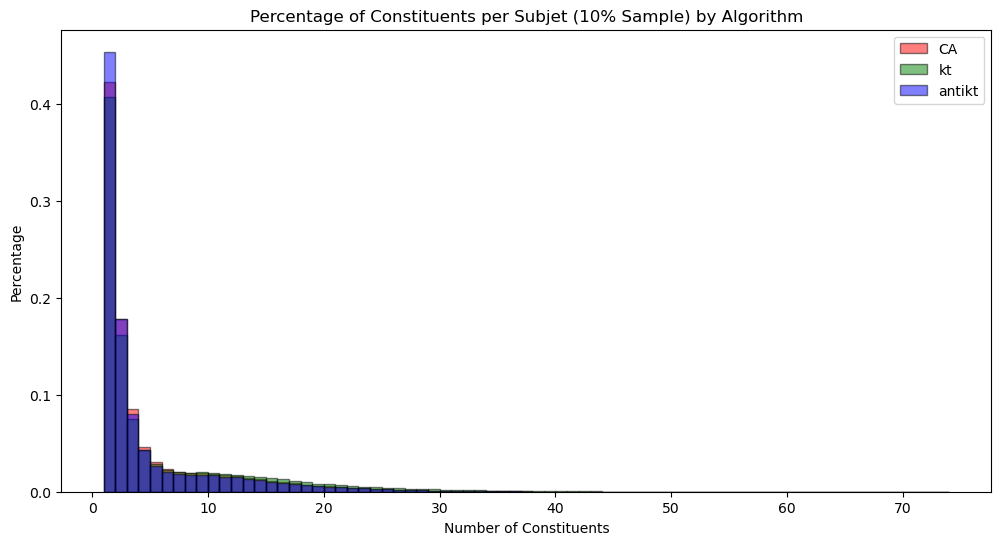

In [32]:
# Plotting histograms with the data for the three choices overlaid
plt.figure(figsize=(12, 6))
max_num_subjets = max(max(num_subjets_per_jet_data[alg]) for alg in algorithms)
bins_subjets = range(min(num_subjets_per_jet_data[alg]), max_num_subjets + 2)
for alg, color in zip(algorithms, colors):
    counts, _, _ = plt.hist(num_subjets_per_jet_data[alg], bins=bins_subjets, alpha=0.5, label=alg, color=color, edgecolor='black', density=True, weights=np.ones(len(num_subjets_per_jet_data[alg])) / len(num_subjets_per_jet_data[alg]))
plt.title('Percentage of Subjets per Jet (10% Sample) by Algorithm')
plt.xlabel('Number of Subjets')
plt.ylabel('Percentage')
plt.legend()
plt.savefig(f"{save_path}/num_subjets_per_jet", bbox_inches='tight', dpi=300)
plt.show()

# Plotting histograms for the number of constituents per subjet as percentages
plt.figure(figsize=(12, 6))
max_num_constituents = max(max(num_constituents_per_subjet_data[alg]) for alg in algorithms)
bins_constituents = range(min(num_constituents_per_subjet_data[alg]), max_num_constituents + 2)
for alg, color in zip(algorithms, colors):
    counts, _, _ = plt.hist(num_constituents_per_subjet_data[alg], bins=bins_constituents, alpha=0.5, label=alg, color=color, edgecolor='black', density=True, weights=np.ones(len(num_constituents_per_subjet_data[alg])) / len(num_constituents_per_subjet_data[alg]))
plt.title('Percentage of Constituents per Subjet (10% Sample) by Algorithm')
plt.xlabel('Number of Constituents')
plt.ylabel('Percentage')
plt.legend()
plt.savefig(f"{save_path}/num_constituents_per_subjet", bbox_inches='tight', dpi=300)
plt.show()

# Increase radius and see if number of single particle subjets changes

Processing 0.1 CA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:20<00:00, 192.52it/s]


59.775669082717656


Processing 0.1 kt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 189.54it/s]


59.59831156379575


Processing 0.1 antikt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:20<00:00, 193.68it/s]


61.27154408316845


Processing 0.2 CA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:20<00:00, 193.24it/s]


42.76759447838877


Processing 0.2 kt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 191.60it/s]


41.446675133075736


Processing 0.2 antikt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:20<00:00, 193.74it/s]


45.73302287826031


Processing 0.30000000000000004 CA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:20<00:00, 193.38it/s]


32.26104982601614


Processing 0.30000000000000004 kt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:20<00:00, 198.10it/s]


28.394140151161707


Processing 0.30000000000000004 antikt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:28<00:00, 143.63it/s]


36.72406210885965


Processing 0.4 CA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:25<00:00, 161.12it/s]


25.937834941050376


Processing 0.4 kt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 172.75it/s]


19.543478260869566


Processing 0.4 antikt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:29<00:00, 138.69it/s]


30.22651853989323


Processing 0.5 CA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:26<00:00, 149.75it/s]


22.62805908723451


Processing 0.5 kt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:30<00:00, 130.29it/s]


11.7613764998868


Processing 0.5 antikt: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:26<00:00, 153.05it/s]


28.79641407717003


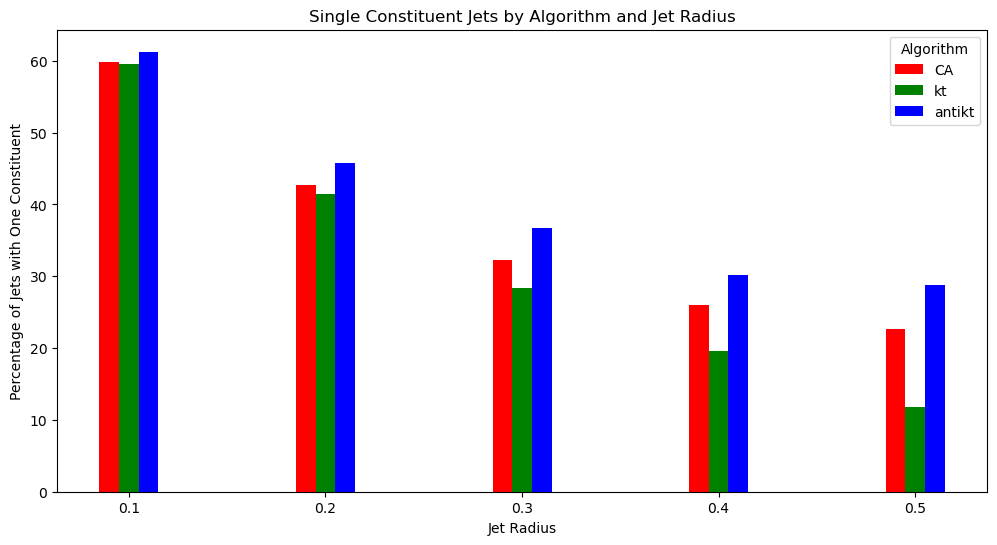

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

jet_radii = np.arange(0.1, 0.6, 0.1)  # Jet radii from 0.1 to 0.5
algorithms = ["CA", "kt", "antikt"]
colors = ['r', 'g', 'b']  # Colors for the bars

sample_size = int(0.01 * len(df))  # 1% of the dataset
sampled_indices = random.sample(range(len(df)), sample_size)

# Prepare a figure
plt.figure(figsize=(12, 6))
width = 0.1  # bar width

for i, radius in enumerate(jet_radii):
    single_const_percentages = []
    
    for j, alg in enumerate(algorithms):
        total_subjets = 0
        single_const_count = 0

        for jet_idx in tqdm.tqdm(sampled_indices, desc=f"Processing {radius} {alg}"):
            cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                                  _py[jet_idx][_py[jet_idx] != 0],
                                  _pz[jet_idx][_pz[jet_idx] != 0],
                                  _e[jet_idx][_e[jet_idx] != 0],
                                  JET_ALGO=alg, 
                                  jet_radius=radius)
            jets = cluster.inclusive_jets()
            total_subjets += len(jets)
            for jet in jets:
                constituents = jet.constituents()
                if len(constituents) == 1:
                    single_const_count += 1
        
        # Calculate percentage
        percentage = (single_const_count / total_subjets) * 100
        single_const_percentages.append(percentage)
        print(percentage)
        plt.bar(i + j * width, percentage, width, color=colors[j], label=f"{alg}" if i == 0 else "")

# Set plot details
plt.xlabel('Jet Radius')
plt.ylabel('Percentage of Jets with One Constituent')
plt.title('Single Constituent Jets by Algorithm and Jet Radius')
plt.xticks(np.arange(len(jet_radii)) + width, [f"{r:.1f}" for r in jet_radii])
plt.legend(title="Algorithm")

plt.savefig(f"{save_path}/single_particle_percent", bbox_inches='tight', dpi=300)
plt.show()


# Number of subjets and number of constituenst per subjet for different radii

Processing radius 0.1 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 186.85it/s]


Processing radius 0.1 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:32<00:00, 123.56it/s]


Processing radius 0.1 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:30<00:00, 131.90it/s]


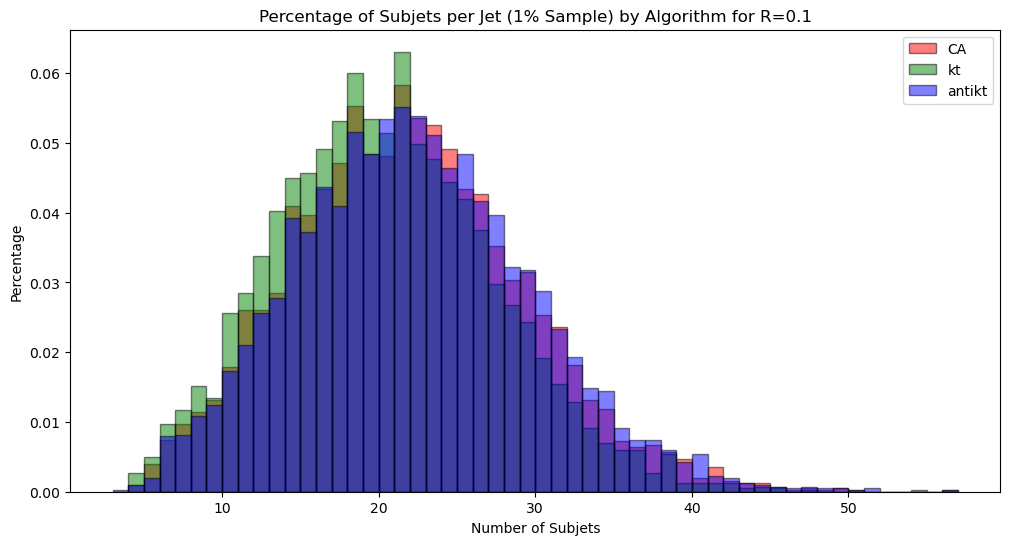

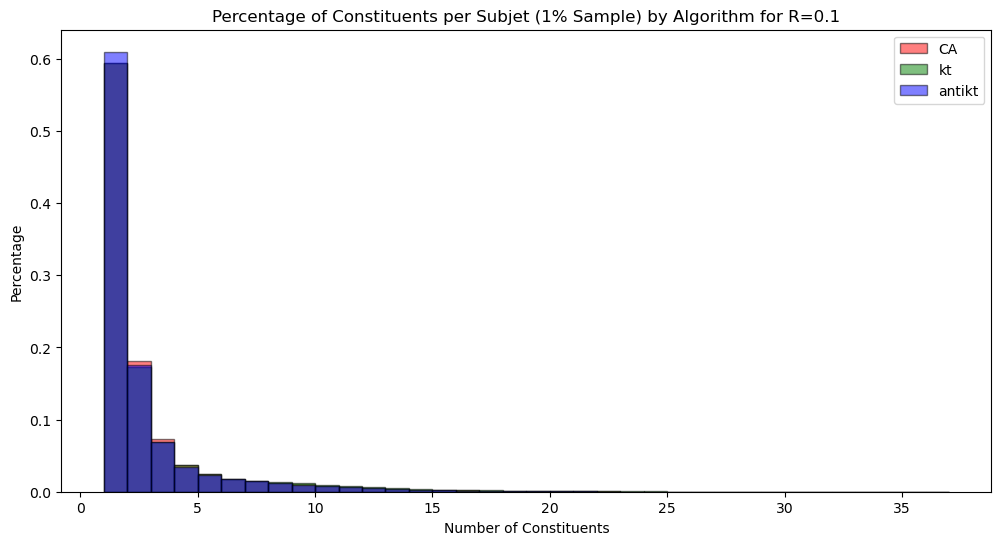

Processing radius 0.2 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:24<00:00, 164.92it/s]


Processing radius 0.2 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:34<00:00, 117.41it/s]


Processing radius 0.2 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 187.57it/s]


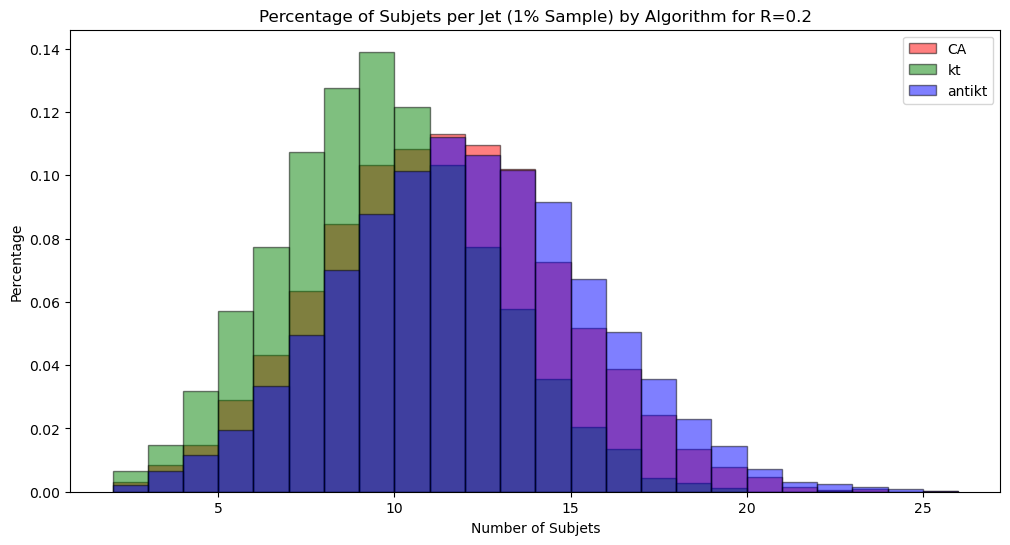

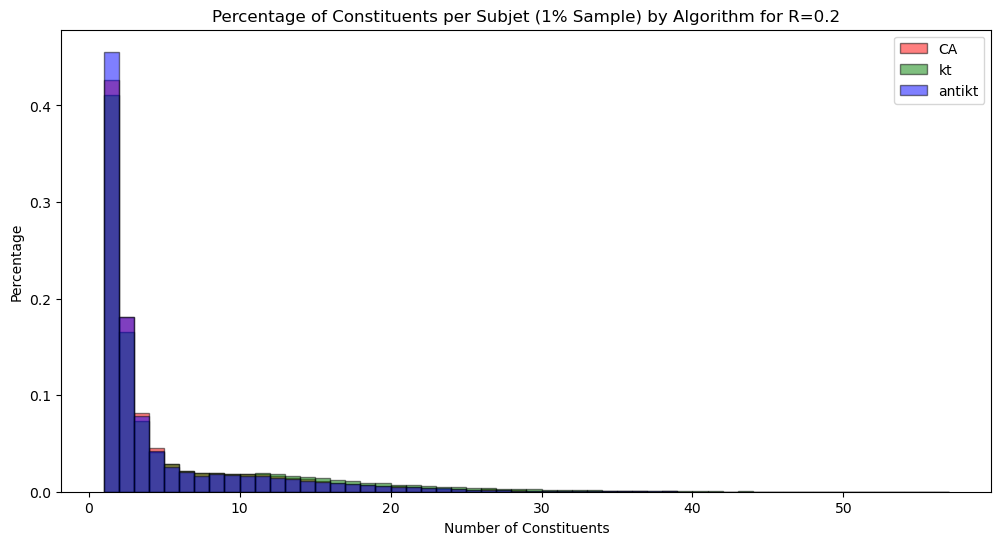

Processing radius 0.3 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:35<00:00, 112.56it/s]


Processing radius 0.3 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 174.80it/s]


Processing radius 0.3 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:29<00:00, 136.61it/s]


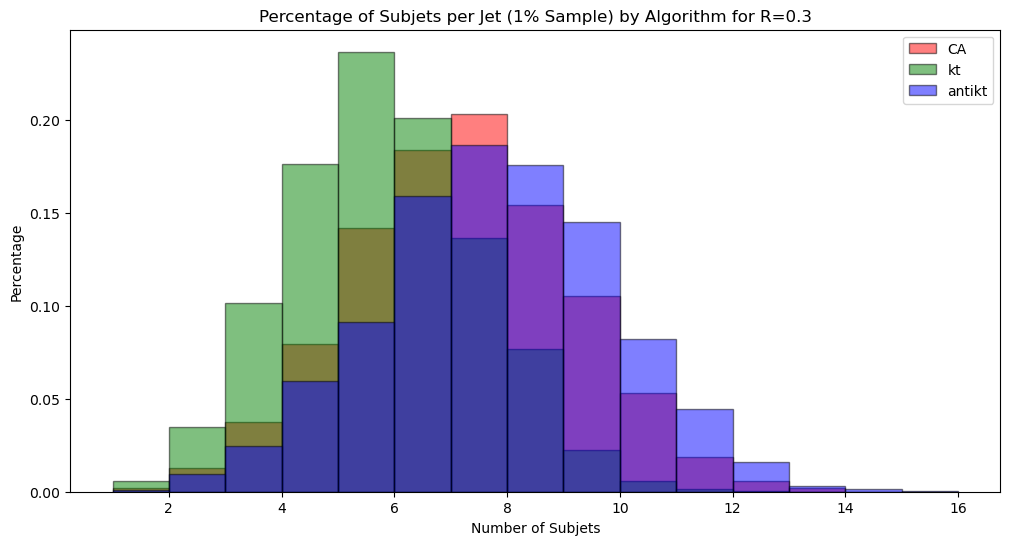

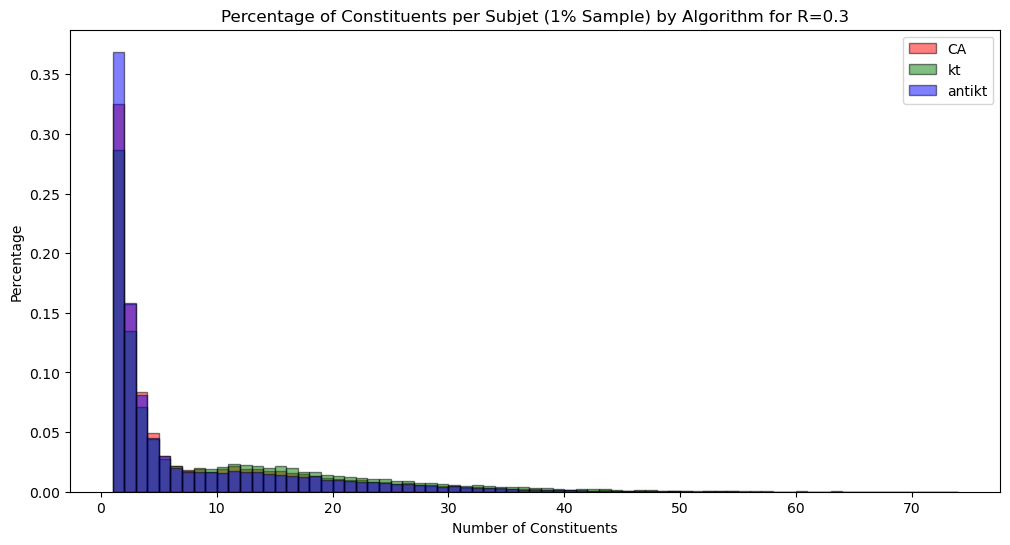

Processing radius 0.4 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:28<00:00, 143.44it/s]


Processing radius 0.4 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:24<00:00, 167.72it/s]


Processing radius 0.4 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:33<00:00, 122.11it/s]


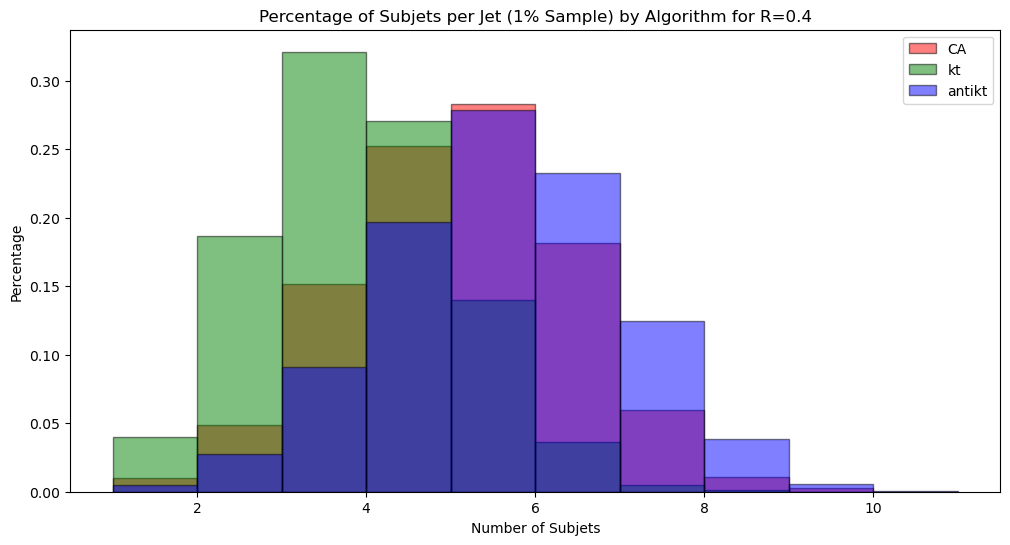

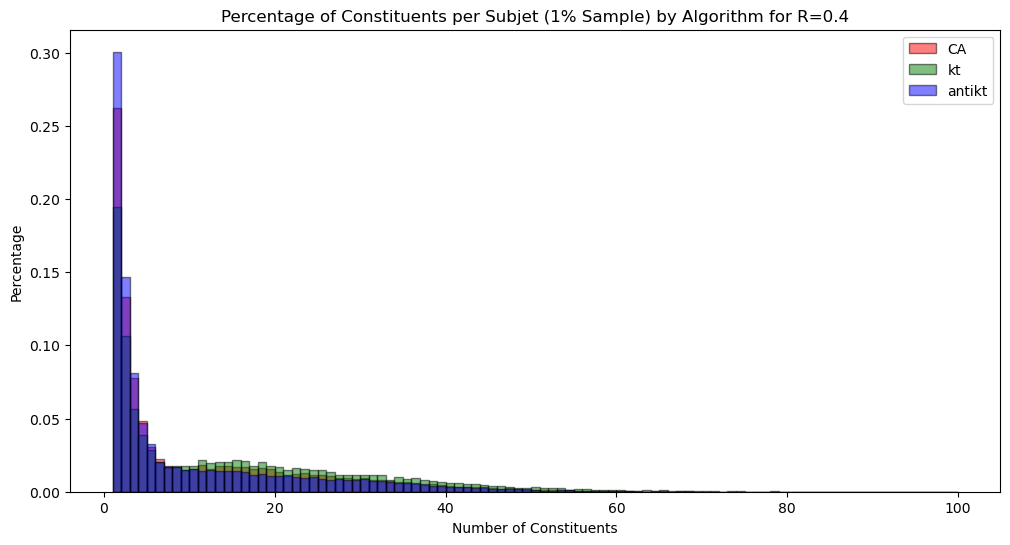

Processing radius 0.5 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 185.59it/s]


Processing radius 0.5 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 184.09it/s]


Processing radius 0.5 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 183.65it/s]


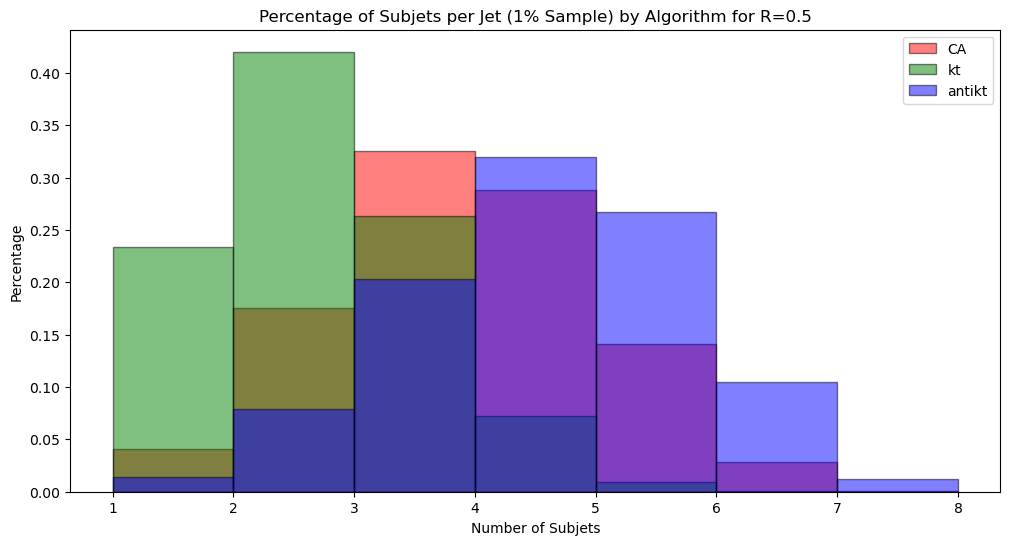

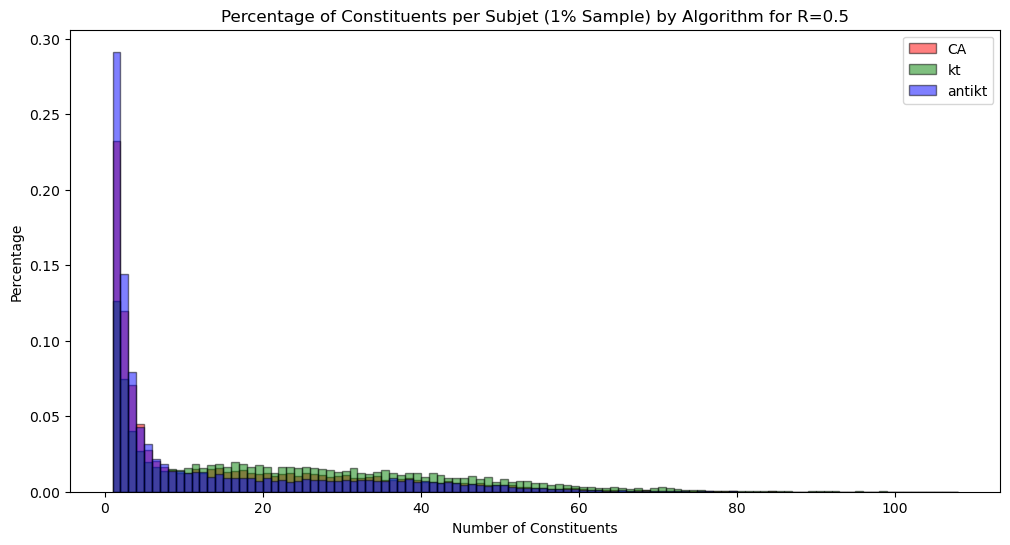

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm

jet_radii = np.arange(0.1, 0.6, 0.1)  # Jet radii from 0.1 to 0.5
algorithms = ["CA", "kt", "antikt"]
colors = ['r', 'g', 'b']  # Colors for the bars

sample_size = int(0.01 * len(df))  # 1% of the dataset
sampled_indices = random.sample(range(len(df)), sample_size)

for radius in jet_radii:
    radius = round(radius,1)
    # Initialize data containers
    total_subjets_data = {alg: [] for alg in algorithms}
    total_constituents_data = {alg: [] for alg in algorithms}
    
    for alg in algorithms:
        print(f"Processing radius {radius} for algorithm {alg}")
        for jet_idx in tqdm.tqdm(sampled_indices):
            cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                              _py[jet_idx][_py[jet_idx] != 0],
                              _pz[jet_idx][_pz[jet_idx] != 0],
                              _e[jet_idx][_e[jet_idx] != 0],
                              JET_ALGO=alg, 
                              jet_radius=radius)
            jets = cluster.inclusive_jets()
            total_subjets_data[alg].append(len(jets))
            for jet in jets:
                constituents = jet.constituents()
                total_constituents_data[alg].append(len(constituents))
    
    # Plotting histograms with the data for the three choices overlaid
    plt.figure(figsize=(12, 6))
    max_num_subjets = max(max(total_subjets_data[alg]) for alg in algorithms)
    bins_subjets = range(min(total_subjets_data[alg]), max_num_subjets + 2)
    for alg, color in zip(algorithms, colors):
        counts, _, _ = plt.hist(total_subjets_data[alg], bins=bins_subjets, alpha=0.5, label=alg, color=color, edgecolor='black', density=True, weights=np.ones(len(total_subjets_data[alg])) / len(total_subjets_data[alg]))
    plt.title(f'Percentage of Subjets per Jet (1% Sample) by Algorithm for R={radius}')
    plt.xlabel('Number of Subjets')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig(f"{save_path}/num_subjets_per_jet_R_{radius}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
    # Plotting histograms for the number of constituents per subjet as percentages
    plt.figure(figsize=(12, 6))
    max_num_constituents = max(max(total_constituents_data[alg]) for alg in algorithms)
    bins_constituents = range(min(total_constituents_data[alg]), max_num_constituents + 2)
    for alg, color in zip(algorithms, colors):
        counts, _, _ = plt.hist(total_constituents_data[alg], bins=bins_constituents, alpha=0.5, label=alg, color=color, edgecolor='black', density=True, weights=np.ones(len(total_constituents_data[alg])) / len(total_constituents_data[alg]))
    plt.title(f'Percentage of Constituents per Subjet (1% Sample) by Algorithm for R={radius}')
    plt.xlabel('Number of Constituents')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig(f"{save_path}/num_constituents_per_subjet_R_{radius}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Number of subjets for different radii

Processing radius 0.1 for algorithm CA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 225.40it/s]


Processing radius 0.2 for algorithm CA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 225.19it/s]


Processing radius 0.3 for algorithm CA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 226.92it/s]


Processing radius 0.4 for algorithm CA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 225.96it/s]


Processing radius 0.5 for algorithm CA


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:18<00:00, 223.48it/s]


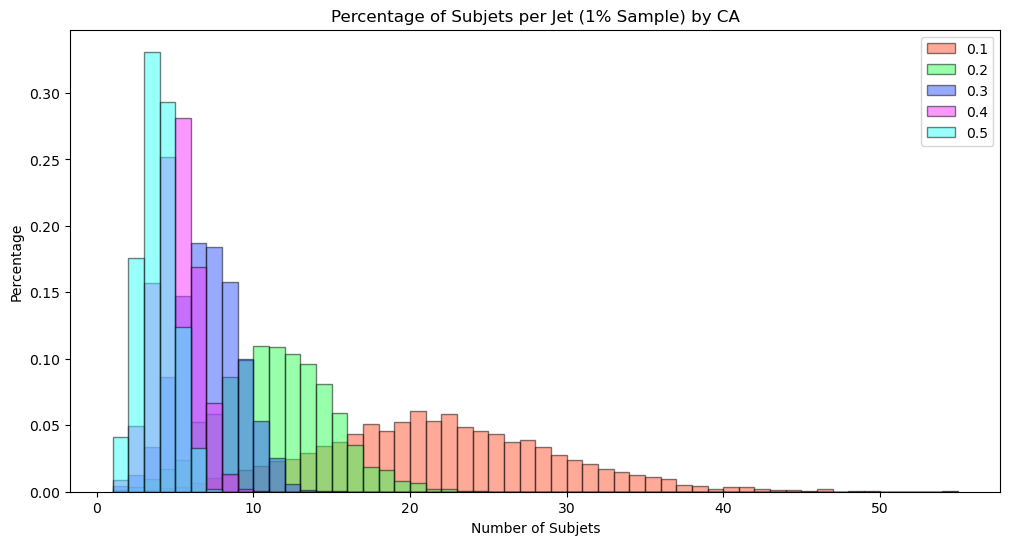

Processing radius 0.1 for algorithm kt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:18<00:00, 221.21it/s]


Processing radius 0.2 for algorithm kt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 226.22it/s]


Processing radius 0.3 for algorithm kt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 226.82it/s]


Processing radius 0.4 for algorithm kt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 228.35it/s]


Processing radius 0.5 for algorithm kt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 229.24it/s]


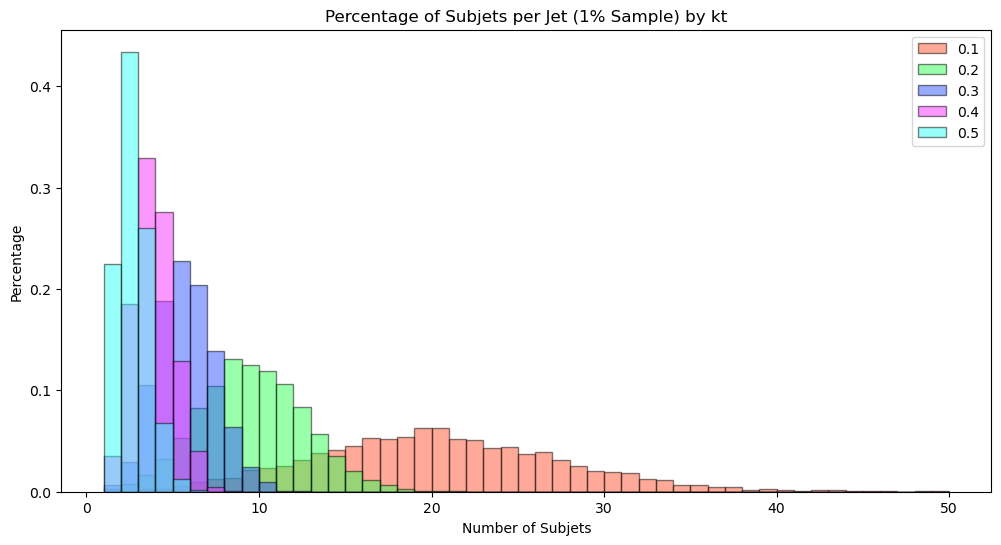

Processing radius 0.1 for algorithm antikt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 226.51it/s]


Processing radius 0.2 for algorithm antikt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 227.44it/s]


Processing radius 0.3 for algorithm antikt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:18<00:00, 222.88it/s]


Processing radius 0.4 for algorithm antikt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 228.18it/s]


Processing radius 0.5 for algorithm antikt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:17<00:00, 227.20it/s]


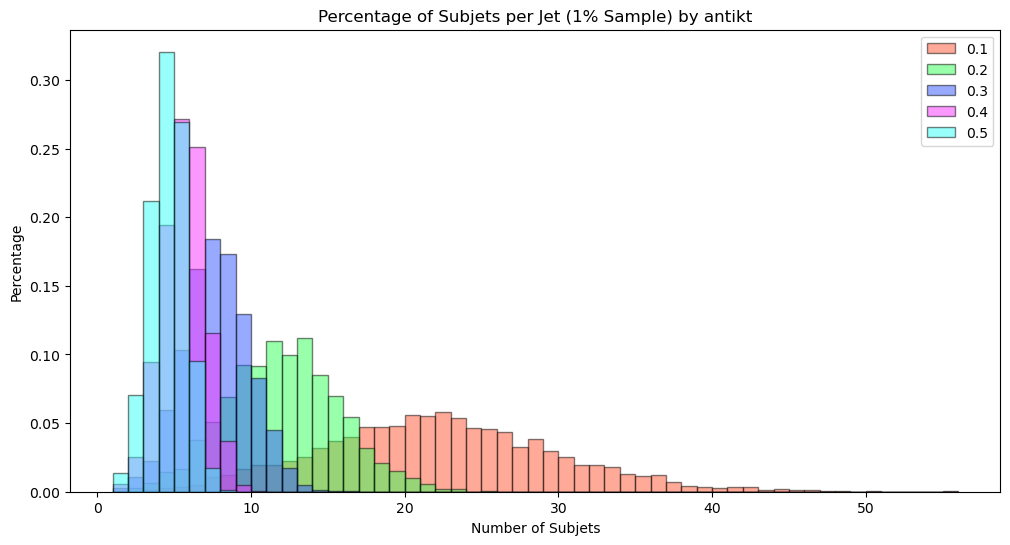

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm

jet_radii = np.arange(0.1, 0.6, 0.1)  # Jet radii from 0.1 to 0.5
algorithms = ["CA", "kt", "antikt"]
# colors = ['r', 'g', 'b']  # Colors for the bars
colors = ['#FF5733',  # Reddish
          '#33FF57',  # Greenish
          '#3357FF',  # Blueish
          '#F833FF',  # Magenta
          '#33FFF6',  # Cyan
          '#F3FF33']  # Yellow

sample_size = int(0.01 * len(df))  # 1% of the dataset
sampled_indices = random.sample(range(len(df)), sample_size)


for alg in algorithms:
    # Initialize data containers
    total_subjets_data = {round(radius,1): [] for radius in jet_radii}
    
    for radius in jet_radii:
        radius = round(radius,1)
        print(f"Processing radius {radius} for algorithm {alg}")
        for jet_idx in tqdm.tqdm(sampled_indices):
            cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                              _py[jet_idx][_py[jet_idx] != 0],
                              _pz[jet_idx][_pz[jet_idx] != 0],
                              _e[jet_idx][_e[jet_idx] != 0],
                              JET_ALGO=alg, 
                              jet_radius=radius)
            jets = cluster.inclusive_jets()
            total_subjets_data[radius].append(len(jets))
    
    # Plotting histograms with the data for the three choices overlaid
    plt.figure(figsize=(12, 6))
    max_num_subjets = max(max(total_subjets_data[round(radius,1)]) for radius in jet_radii)
    bins_subjets = range(min(total_subjets_data[round(radius,1)]), max_num_subjets + 2)
    for radius, color in zip(jet_radii, colors):
        counts, _, _ = plt.hist(total_subjets_data[round(radius,1)], bins=bins_subjets, alpha=0.5, label=round(radius,1), color=color, edgecolor='black', density=True, weights=np.ones(len(total_subjets_data[round(radius,1)])) / len(total_subjets_data[round(radius,1)]))
    plt.title(f'Percentage of Subjets per Jet (1% Sample) by {alg}')
    plt.xlabel('Number of Subjets')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig(f"{save_path}/num_subjets_per_jet_multiple_R_{alg}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# plot the pt distribution of subjets

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

jet_radius = 0.2
# Assuming _px, _py, _pz, _e are your jet component arrays and get_subjets is your function to get subjets

# Sample 10% of the data randomly
sample_size = int(0.01 * len(df))  # Calculate 10% of your dataset size
sampled_indices = random.sample(range(len(df)), sample_size)  # Get random indices

# Lists to hold the data for histograms
pt_values_single_constituent = []
pt_values_all_subjets = []

for jet_idx in tqdm.tqdm(sampled_indices):  # Iterate over sampled indices
    # print(f"non zero constituents of jet {jet_idx}: {np.count_nonzero(_px[jet_idx])}")
    cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0], _py[jet_idx][_py[jet_idx] != 0], _pz[jet_idx][_pz[jet_idx] != 0], _e[jet_idx][_e[jet_idx] != 0], JET_ALGO="kt", jet_radius=jet_radius)
    jets = cluster.inclusive_jets()
    for i, jet in enumerate(jets):
        pt_values_all_subjets.append(jet.pt())
        if len(jet.constituents()) == 1:
            # Get the pT of the subjet and add it to the list
            pt_values_single_constituent.append(jet.pt())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 170.35it/s]


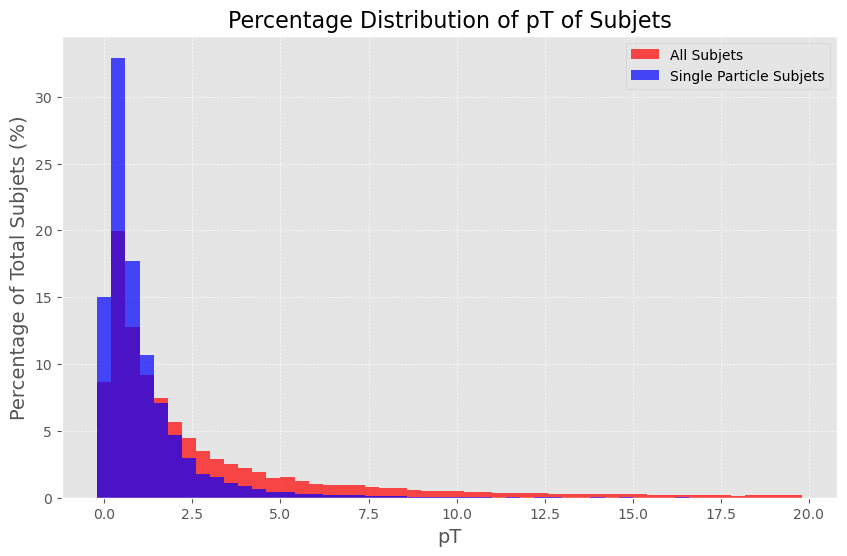

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Given lists: pt_values_all_subjets, pt_values_single_constituent
r_max = 20
bin_width = r_max / 50  # Assuming 50 bins as specified in your original plt.hist call

# Calculate histograms
hist_all, bin_edges = np.histogram(pt_values_all_subjets, bins=50, range=(0, r_max))
hist_single, _ = np.histogram(pt_values_single_constituent, bins=50, range=(0, r_max))

# Normalize to get percentages
hist_all = (hist_all / sum(hist_all)) * 100
hist_single = (hist_single / sum(hist_single)) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_all, width=bin_width, alpha=0.7, label='All Subjets', color='red')
plt.bar(bin_edges[:-1], hist_single, width=bin_width, alpha=0.7, label='Single Particle Subjets', color='blue')

# Set axis labels and title
plt.xlabel('pT', fontsize=14)
plt.ylabel('Percentage of Total Subjets (%)', fontsize=14)
plt.title('Percentage Distribution of pT of Subjets', fontsize=16)

# Add the legend
plt.legend()

# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Save the figure if needed, uncomment the next line
plt.savefig(f"{save_path}/pT_distribution_0-{r_max}.png", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


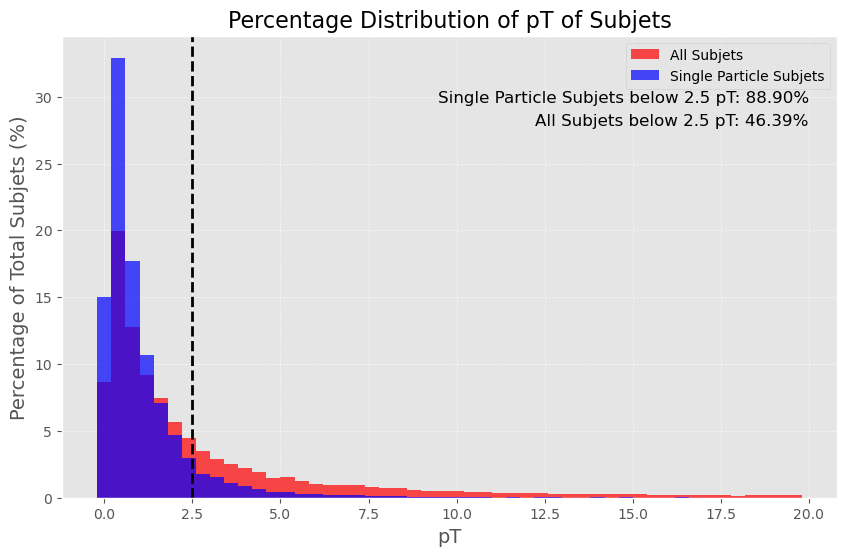

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'pt_values_single_constituent' is defined and holds the pT values
r_max = 20
bin_width = r_max / 50  # Assuming 50 bins as specified in your original plt.hist call

# Calculate histograms
hist_all, bin_edges = np.histogram(pt_values_all_subjets, bins=50, range=(0, r_max))
hist_single, _ = np.histogram(pt_values_single_constituent, bins=50, range=(0, r_max))

# Normalize to get percentages
hist_all = (hist_all / sum(hist_all)) * 100
hist_single = (hist_single / sum(hist_single)) * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist_all, width=bin_width, alpha=0.7, label='All Subjets', color='red')
plt.bar(bin_edges[:-1], hist_single, width=bin_width, alpha=0.7, label='Single Particle Subjets', color='blue')

# Set axis labels and title
plt.xlabel('pT', fontsize=14)
plt.ylabel('Percentage of Total Subjets (%)', fontsize=14)
plt.title('Percentage Distribution of pT of Subjets', fontsize=16)

# Draw a dashed vertical line at x = 2.5
plt.axvline(x=2.5, color='black', linestyle='--', linewidth=2)

# Calculate the percentage of single particle subjets with pT below 2.5
below_threshold_percentage_single = (np.sum(np.array(pt_values_single_constituent) < 2.5) / len(pt_values_single_constituent)) * 100

# Calculate the percentage of all subjets with pT below 2.5
below_threshold_percentage_all = (np.sum(np.array(pt_values_all_subjets) < 2.5) / len(pt_values_all_subjets)) * 100

# Add text annotations for the percentages in the top right corner
plt.text(r_max, plt.ylim()[1]*0.85, f"Single Particle Subjets below 2.5 pT: {below_threshold_percentage_single:.2f}%", 
         ha='right', va='bottom', fontsize=12)
plt.text(r_max, plt.ylim()[1]*0.8, f"All Subjets below 2.5 pT: {below_threshold_percentage_all:.2f}%", 
         ha='right', va='bottom', fontsize=12)


# Add the legend
plt.legend()

# Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.savefig(f"{save_path}/pT_distribution_0-{r_max}.png", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

# Note: You will have to adjust `save_path` to the correct path if you wish to save the plot.


## Apply a pT cut

In [51]:
cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                              _py[jet_idx][_py[jet_idx] != 0],
                              _pz[jet_idx][_pz[jet_idx] != 0],
                              _e[jet_idx][_e[jet_idx] != 0])
jets = cluster.inclusive_jets()

In [53]:
[jet for jet in jets if jet.pt() >= 2.5]

[<fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b11bc0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b12280> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b12130> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b0ad00> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b09aa0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b09ec0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fc2a8b0b720> >]

Processing radius 0.1 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 177.41it/s]


Processing radius 0.1 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 178.30it/s]


Processing radius 0.1 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 181.52it/s]


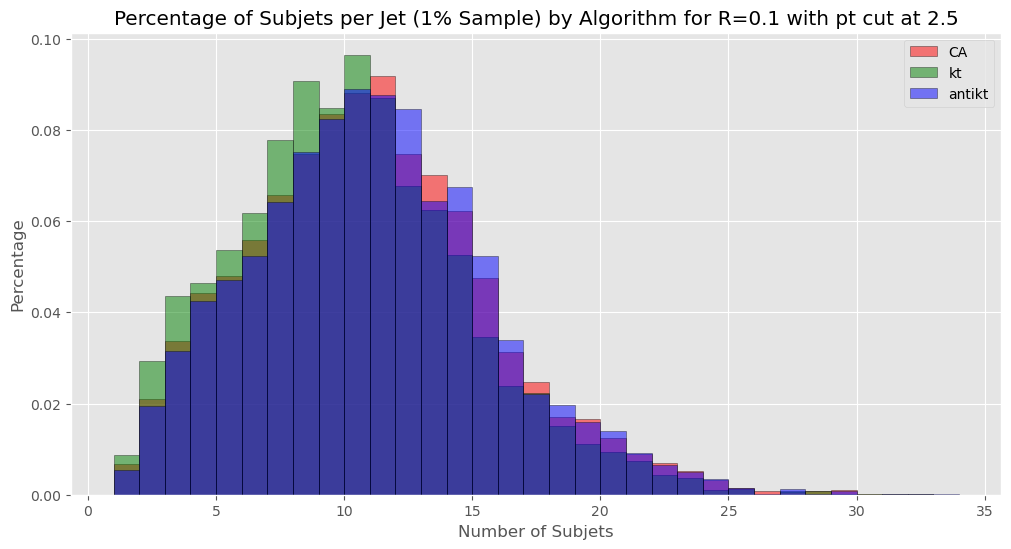

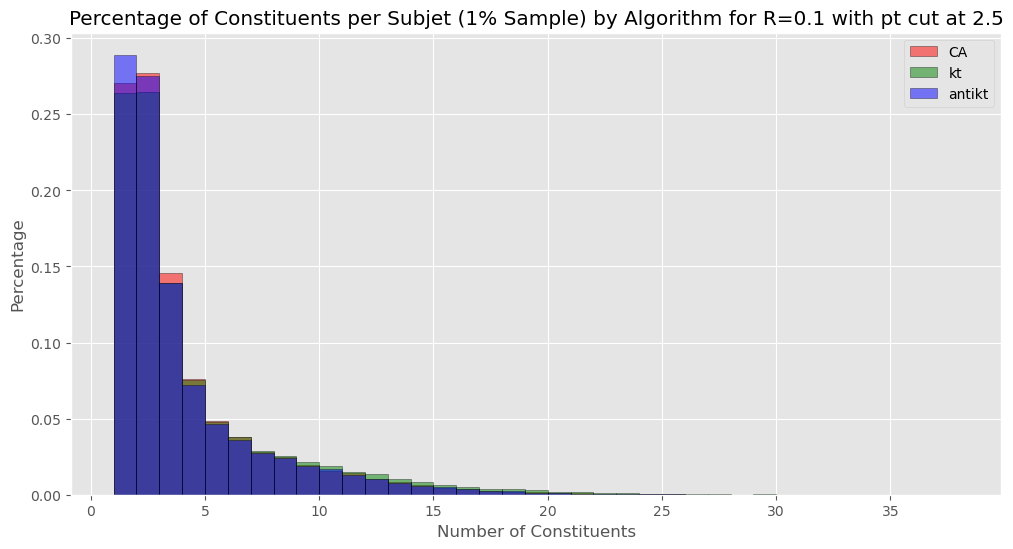

Processing radius 0.2 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 176.28it/s]


Processing radius 0.2 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 176.20it/s]


Processing radius 0.2 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 179.32it/s]


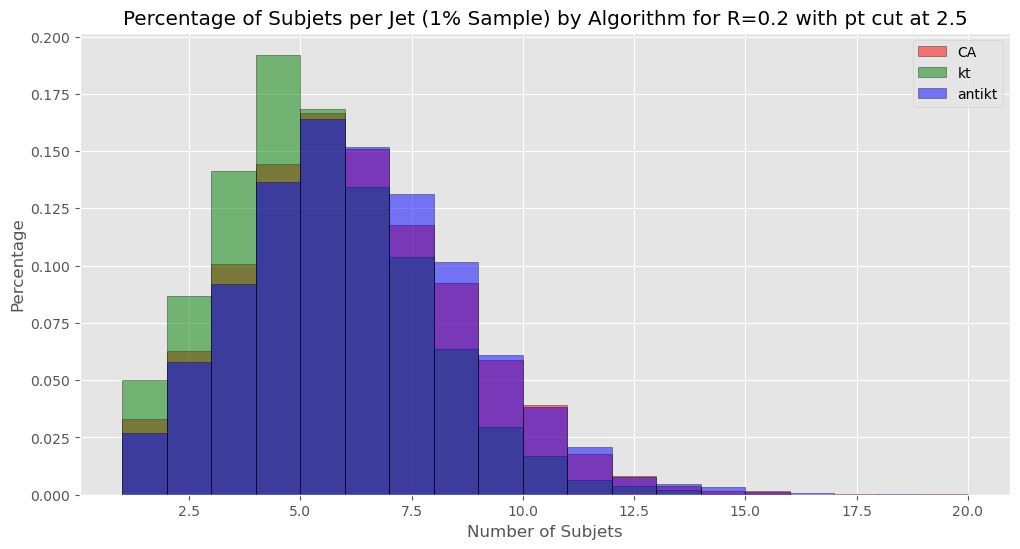

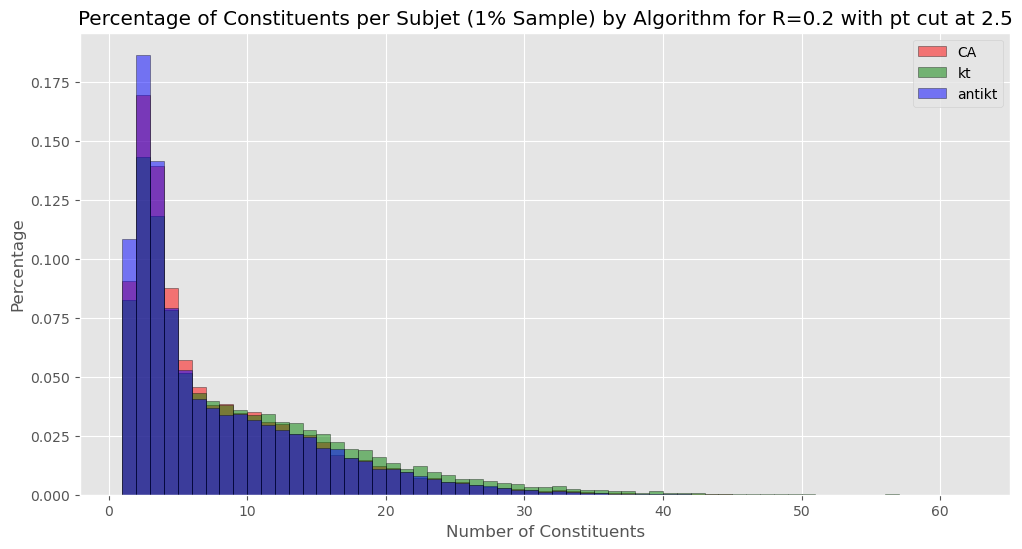

Processing radius 0.3 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 175.03it/s]


Processing radius 0.3 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 167.97it/s]


Processing radius 0.3 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 173.69it/s]


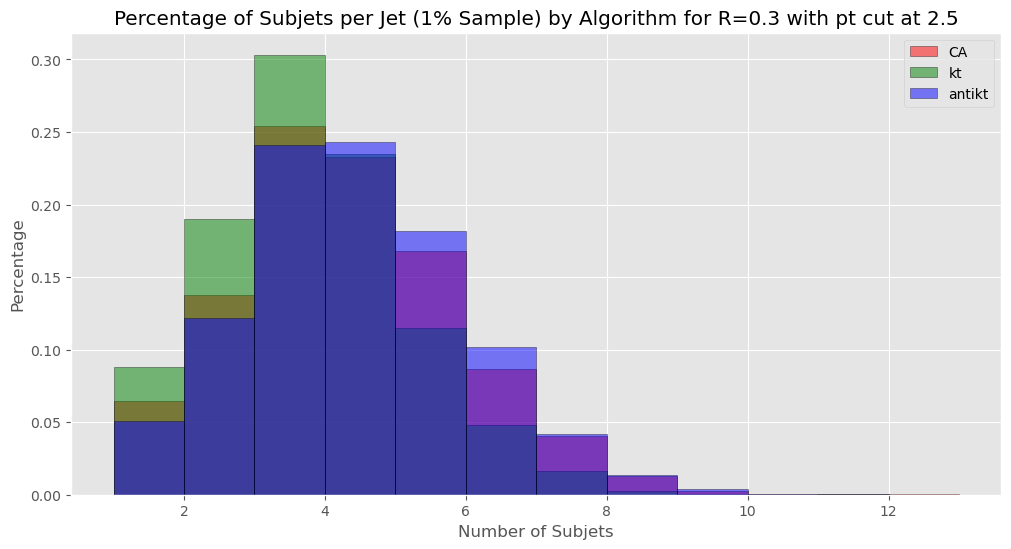

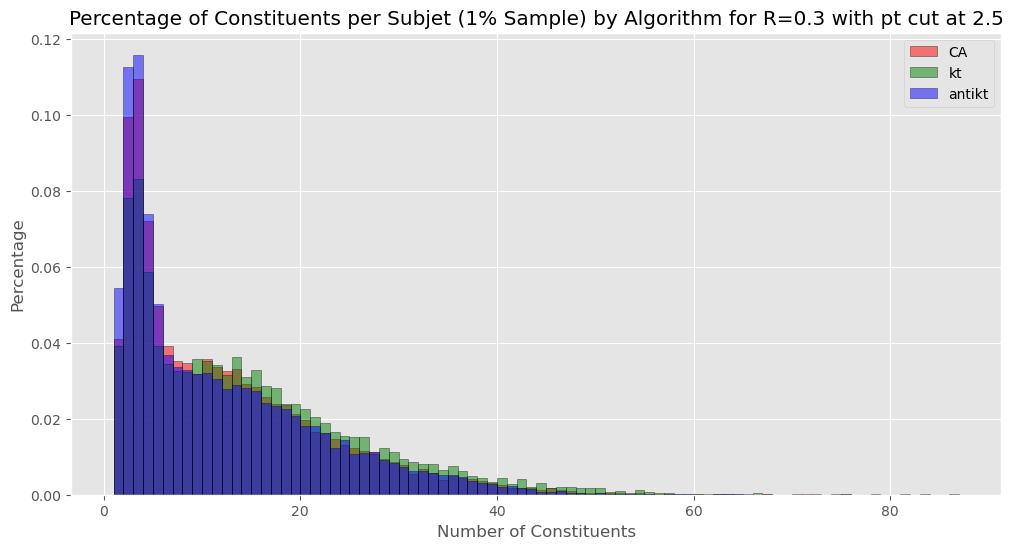

Processing radius 0.4 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 183.35it/s]


Processing radius 0.4 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 179.09it/s]


Processing radius 0.4 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 191.02it/s]


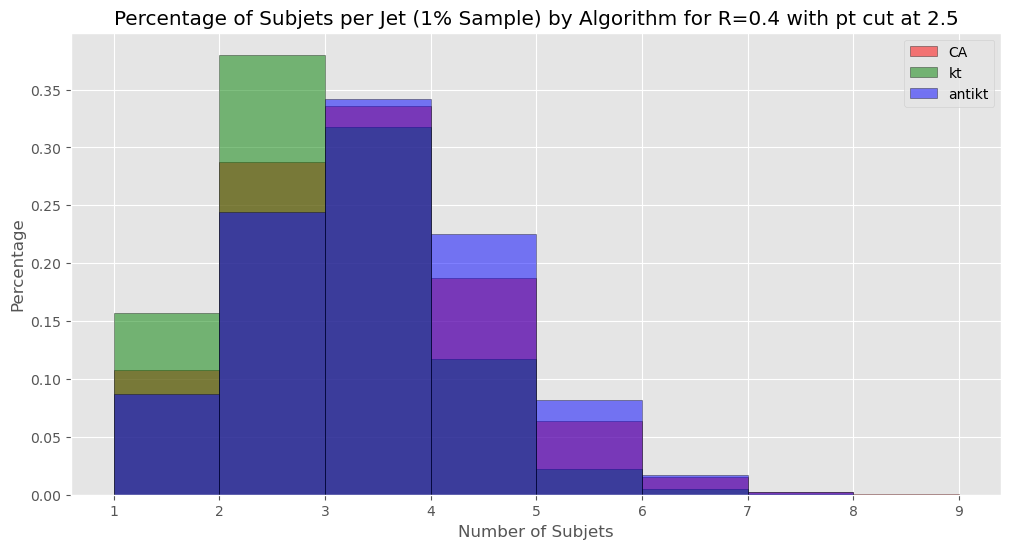

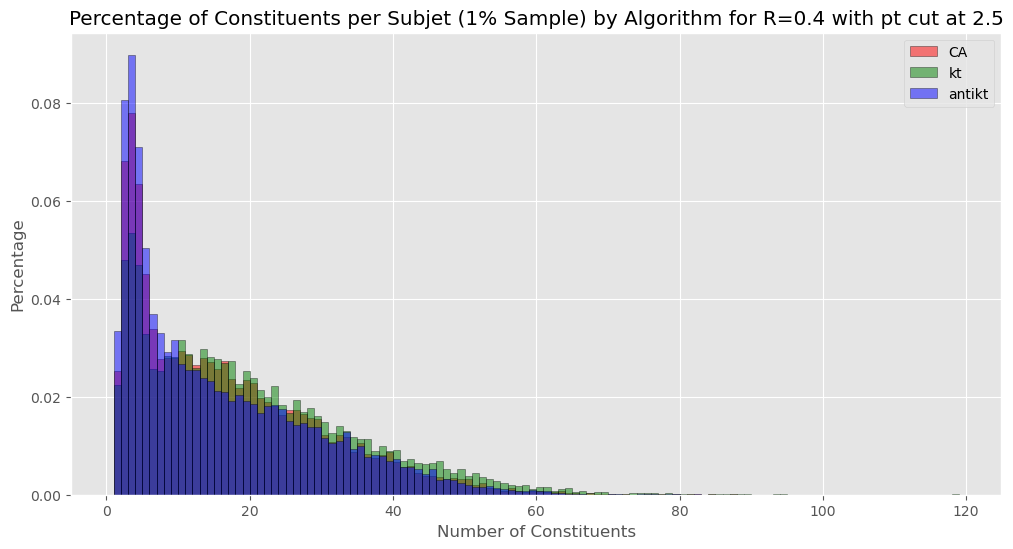

Processing radius 0.5 for algorithm CA


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 175.30it/s]


Processing radius 0.5 for algorithm kt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:21<00:00, 184.85it/s]


Processing radius 0.5 for algorithm antikt


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:22<00:00, 180.06it/s]


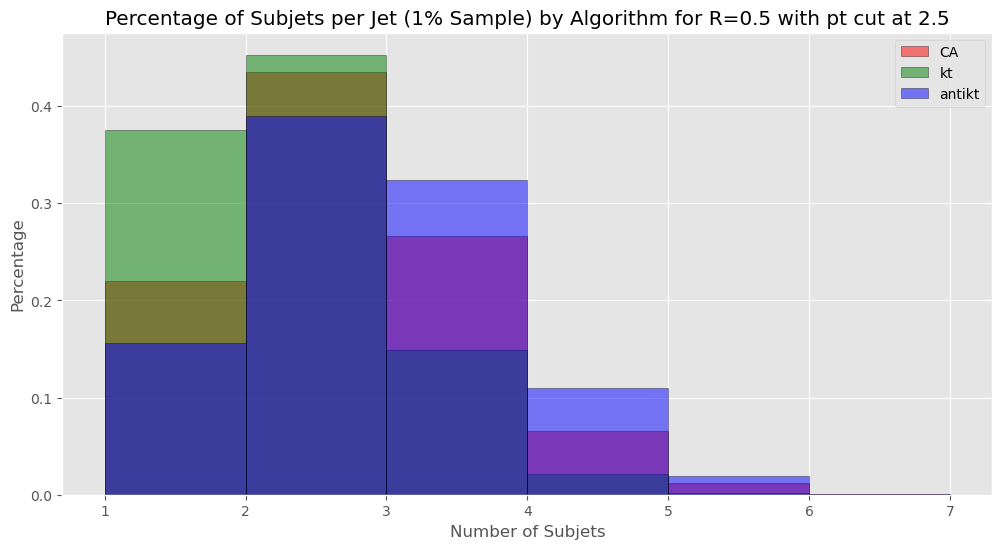

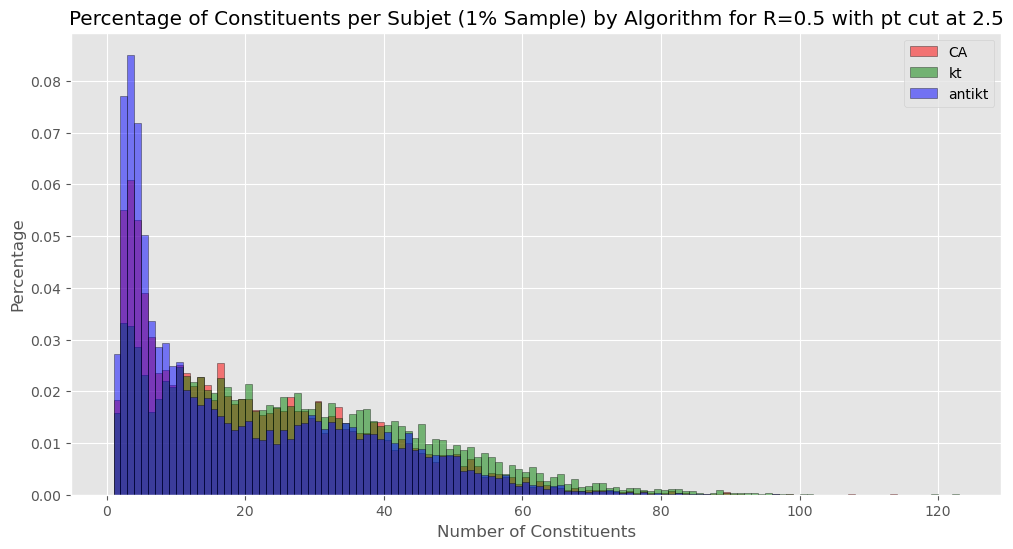

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm

jet_radii = np.arange(0.1, 0.6, 0.1)  # Jet radii from 0.1 to 0.5
algorithms = ["CA", "kt", "antikt"]
colors = ['r', 'g', 'b']  # Colors for the bars

sample_size = int(0.01 * len(df))  # 1% of the dataset
sampled_indices = random.sample(range(len(df)), sample_size)
pt_cut = 2.5

for radius in jet_radii:
    radius = round(radius,1)
    # Initialize data containers
    total_subjets_data = {alg: [] for alg in algorithms}
    total_constituents_data = {alg: [] for alg in algorithms}
    
    for alg in algorithms:
        print(f"Processing radius {radius} for algorithm {alg}")
        for jet_idx in tqdm.tqdm(sampled_indices):
            cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                              _py[jet_idx][_py[jet_idx] != 0],
                              _pz[jet_idx][_pz[jet_idx] != 0],
                              _e[jet_idx][_e[jet_idx] != 0],
                              JET_ALGO=alg, 
                              jet_radius=radius)
            jets = cluster.inclusive_jets()
            jets = [jet for jet in jets if jet.pt() >= pt_cut]
            total_subjets_data[alg].append(len(jets))
            for jet in jets:
                constituents = jet.constituents()
                total_constituents_data[alg].append(len(constituents))
    
    # Plotting histograms with the data for the three choices overlaid
    plt.figure(figsize=(12, 6))
    max_num_subjets = max(max(total_subjets_data[alg]) for alg in algorithms)
    bins_subjets = range(min(total_subjets_data[alg]), max_num_subjets + 2)
    for alg, color in zip(algorithms, colors):
        counts, _, _ = plt.hist(total_subjets_data[alg], bins=bins_subjets, alpha=0.5, label=alg, color=color, edgecolor='black', density=True, weights=np.ones(len(total_subjets_data[alg])) / len(total_subjets_data[alg]))
    plt.title(f'Percentage of Subjets per Jet (1% Sample) by Algorithm for R={radius} with pt cut at {pt_cut}')
    plt.xlabel('Number of Subjets')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig(f"{save_path}/num_subjets_per_jet_R_{radius}_pt_cut_{pt_cut}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
    # Plotting histograms for the number of constituents per subjet as percentages
    plt.figure(figsize=(12, 6))
    max_num_constituents = max(max(total_constituents_data[alg]) for alg in algorithms)
    bins_constituents = range(min(total_constituents_data[alg]), max_num_constituents + 2)
    for alg, color in zip(algorithms, colors):
        counts, _, _ = plt.hist(total_constituents_data[alg], bins=bins_constituents, alpha=0.5, label=alg, color=color, edgecolor='black', density=True, weights=np.ones(len(total_constituents_data[alg])) / len(total_constituents_data[alg]))
    plt.title(f'Percentage of Constituents per Subjet (1% Sample) by Algorithm for R={radius} with pt cut at {pt_cut}')
    plt.xlabel('Number of Constituents')
    plt.ylabel('Percentage')
    plt.legend()
    plt.savefig(f"{save_path}/num_constituents_per_subjet_R_{radius}_pt_cut_{pt_cut}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

## Compare number of subjets before and after pT cut

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 172.57it/s]


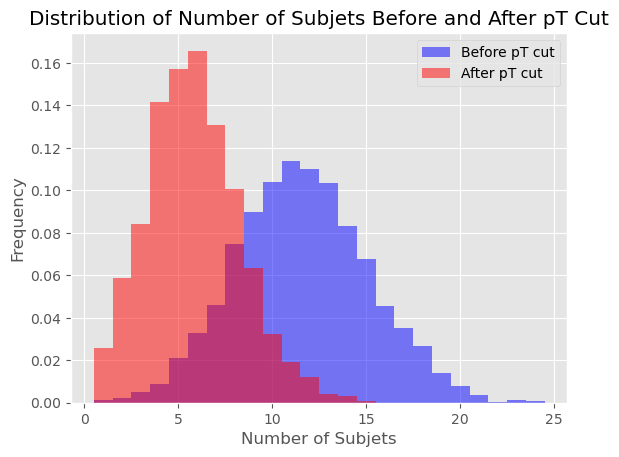

In [71]:
import matplotlib.pyplot as plt

# Placeholder lists to store the number of subjets per jet before and after the pT cut
num_subjets_before_pt_cut = []
num_subjets_after_pt_cut = []

for jet_idx in tqdm.tqdm(sampled_indices):
    cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                      _py[jet_idx][_py[jet_idx] != 0],
                      _pz[jet_idx][_pz[jet_idx] != 0],
                      _e[jet_idx][_e[jet_idx] != 0],
                      JET_ALGO='antikt', 
                      jet_radius=0.2)
    jets = cluster.inclusive_jets()
    after_jets = [jet for jet in jets if jet.pt() >= pt_cut]
    num_subjets_before_pt_cut.append(len(jets))
    num_subjets_after_pt_cut.append(len(after_jets))

# Plotting the histograms
plt.hist(num_subjets_before_pt_cut, bins=np.arange(min(num_subjets_before_pt_cut), max(num_subjets_before_pt_cut) + 1) - 0.5, alpha=0.5, density=True, label='Before pT cut', color='blue')
plt.hist(num_subjets_after_pt_cut, bins=np.arange(min(num_subjets_after_pt_cut), max(num_subjets_after_pt_cut) + 1) - 0.5, alpha=0.5, density=True, label='After pT cut', color='red')

# Adding plot details
plt.xlabel('Number of Subjets')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Subjets Before and After pT Cut')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_path}/num_subjets_before_after_pt_cut_{pt_cut}.png", bbox_inches='tight', dpi=300)
plt.show()


## Compare number of constituents per subjet before and after pT cut

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:23<00:00, 171.63it/s]


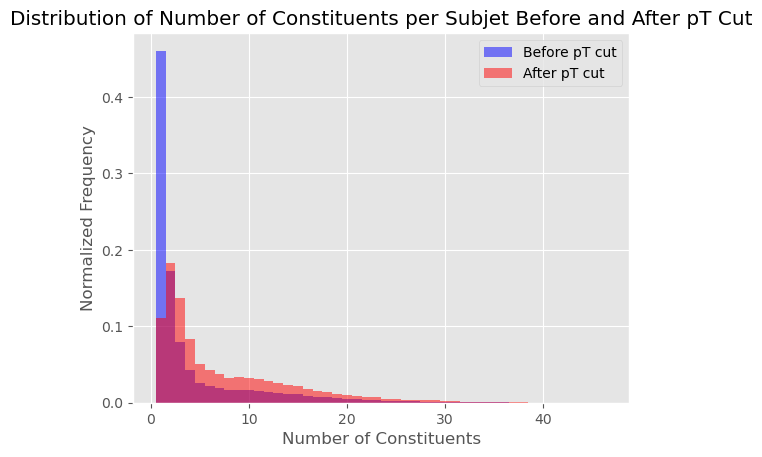

In [72]:
import matplotlib.pyplot as plt
import tqdm

# Placeholder lists to store the number of constituents per subjet before and after the pT cut
num_constituents_before_pt_cut = []
num_constituents_after_pt_cut = []
pt_cut = 2.5  # Define the pT cut value

for jet_idx in tqdm.tqdm(sampled_indices):
    cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                          _py[jet_idx][_py[jet_idx] != 0],
                          _pz[jet_idx][_pz[jet_idx] != 0],
                          _e[jet_idx][_e[jet_idx] != 0],
                          JET_ALGO='antikt', 
                          jet_radius=0.2)
    jets = cluster.inclusive_jets()

    # For before pT cut, count constituents in all subjets
    for subjet in jets:
        num_constituents_before_pt_cut.extend([len(subjet.constituents())])

    # For after pT cut, only count constituents in subjets that pass the pT cut
    for subjet in [jet for jet in jets if jet.pt() >= pt_cut]:
        num_constituents_after_pt_cut.extend([len(subjet.constituents())])

# Determine the range for the histogram bins
min_bin = min(min(num_constituents_before_pt_cut), min(num_constituents_after_pt_cut))
max_bin = max(max(num_constituents_before_pt_cut), max(num_constituents_after_pt_cut))

# Plotting the histograms
plt.hist(num_constituents_before_pt_cut, bins=np.arange(min_bin, max_bin + 1) - 0.5, alpha=0.5, density=True, label='Before pT cut', color='blue')
plt.hist(num_constituents_after_pt_cut, bins=np.arange(min_bin, max_bin + 1) - 0.5, alpha=0.5, density=True, label='After pT cut', color='red')

# Adding plot details
plt.xlabel('Number of Constituents')
plt.ylabel('Normalized Frequency')
plt.title('Distribution of Number of Constituents per Subjet Before and After pT Cut')
plt.legend()
plt.grid(True)
plt.savefig(f"{save_path}/num_constituents_before_after_pt_cut_{pt_cut}.png", bbox_inches='tight', dpi=300)
plt.show()


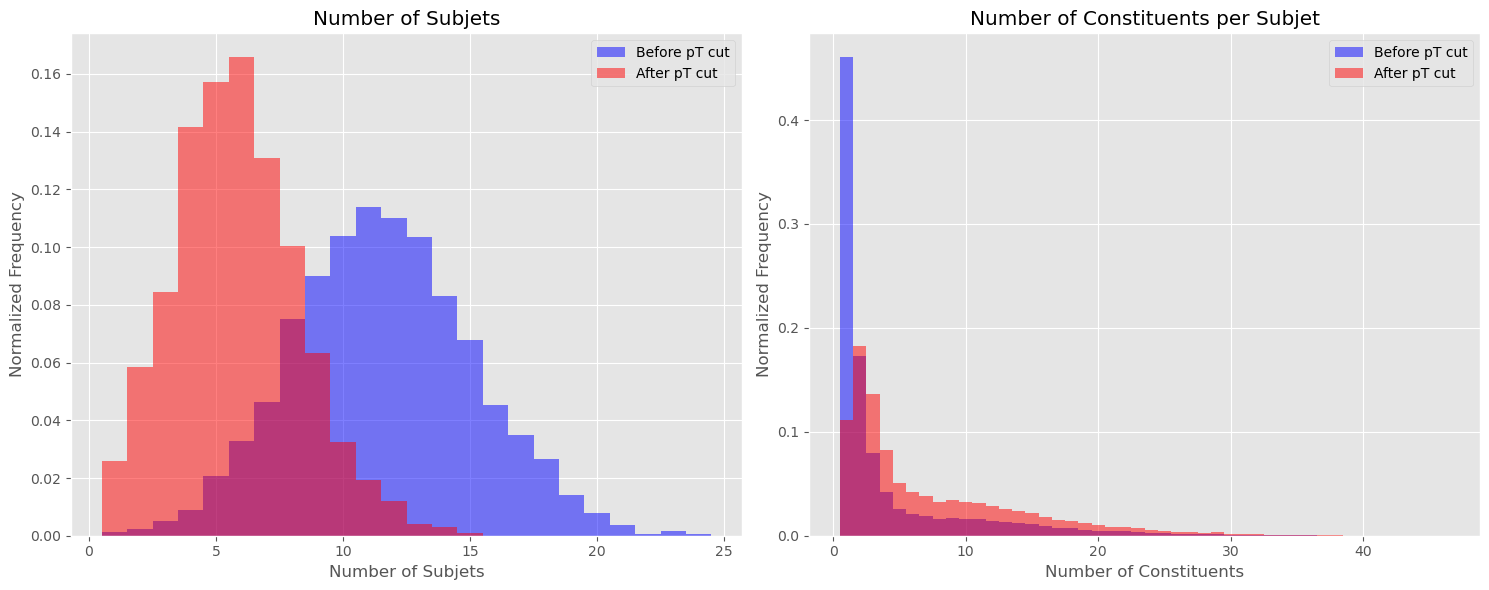

In [74]:
import matplotlib.pyplot as plt

# Assuming the following lists have been obtained:
# num_subjets_before_pt_cut, num_subjets_after_pt_cut
# num_constituents_before_pt_cut, num_constituents_after_pt_cut

# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # figsize can be adjusted to your preference

# Plot the number of subjets before and after the pT cut
axes[0].hist(num_subjets_before_pt_cut, bins=np.arange(min(num_subjets_before_pt_cut), max(num_subjets_before_pt_cut) + 1) - 0.5, alpha=0.5, density=True, label='Before pT cut', color='blue')
axes[0].hist(num_subjets_after_pt_cut, bins=np.arange(min(num_subjets_after_pt_cut), max(num_subjets_after_pt_cut) + 1) - 0.5, alpha=0.5, density=True, label='After pT cut', color='red')
axes[0].set_title('Number of Subjets')
axes[0].set_xlabel('Number of Subjets')
axes[0].set_ylabel('Normalized Frequency')
axes[0].legend()
axes[0].grid(True)

# Plot the number of constituents per subjet before and after the pT cut
axes[1].hist(num_constituents_before_pt_cut, bins=np.arange(min(num_constituents_before_pt_cut), max(num_constituents_before_pt_cut) + 1) - 0.5, alpha=0.5, density=True, label='Before pT cut', color='blue')
axes[1].hist(num_constituents_after_pt_cut, bins=np.arange(min(num_constituents_after_pt_cut), max(num_constituents_after_pt_cut) + 1) - 0.5, alpha=0.5, density=True, label='After pT cut', color='red')
axes[1].set_title('Number of Constituents per Subjet')
axes[1].set_xlabel('Number of Constituents')
axes[1].set_ylabel('Normalized Frequency')
axes[1].legend()
axes[1].grid(True)

# Adjust the layout so that the subplots fit into the figure area nicely
plt.tight_layout()

# Save the figure if needed
plt.savefig(f"{save_path}/comparison_subjets_constituents_pt_cut_{pt_cut}.png", bbox_inches='tight', dpi=300)

# Show the figure
plt.show()


## Percentage of single particle subjets after pt cut

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random

# Assuming 'df', 'get_subjets', and other necessary variables and functions are already defined

jet_radii = np.arange(0.1, 0.6, 0.1)  # Jet radii from 0.1 to 0.5
algorithms = ["CA", "kt", "antikt"]
sample_size = int(0.01 * len(df))  # 1% of the dataset
sampled_indices = random.sample(range(len(df)), sample_size)
pt_cut = 2.5

# Set a nice style for the plots
plt.style.use('seaborn-darkgrid')

# Create the figure with subplots
fig, axes = plt.subplots(1, len(algorithms), figsize=(20, 6), sharey=True)

# Set a larger bar width for better visibility
bar_width = 0.35

results_dict_before = {alg:[] for alg in algorithms}
results_dict_after = {alg:[] for alg in algorithms}

for j, alg in enumerate(algorithms):
    single_const_percentages_before = results_dict_before[alg]
    single_const_percentages_after = results_dict_after[alg]

    for i, radius in enumerate(jet_radii):
        total_subjets_before = 0
        single_const_count_before = 0
        total_subjets_after = 0
        single_const_count_after = 0

        print(f"Processing radius {radius} for algorithm {alg}")
        for jet_idx in tqdm.tqdm(sampled_indices):
            # Replace with your actual logic to retrieve subjets
            cluster = get_subjets(_px[jet_idx][_px[jet_idx] != 0],
                                  _py[jet_idx][_py[jet_idx] != 0],
                                  _pz[jet_idx][_pz[jet_idx] != 0],
                                  _e[jet_idx][_e[jet_idx] != 0],
                                  JET_ALGO=alg, 
                                  jet_radius=radius)
            jets = cluster.inclusive_jets()
            subjets_before = jets
            subjets_after = [subjet for subjet in jets if subjet.pt() >= pt_cut]

            total_subjets_before += len(subjets_before)
            total_subjets_after += len(subjets_after)

            single_const_count_before += sum(1 for subjet in subjets_before if len(subjet.constituents()) == 1)
            single_const_count_after += sum(1 for subjet in subjets_after if len(subjet.constituents()) == 1)

        percentage_before = (single_const_count_before / total_subjets_before) * 100 if total_subjets_before > 0 else 0
        percentage_after = (single_const_count_after / total_subjets_after) * 100 if total_subjets_after > 0 else 0

        single_const_percentages_before.append(percentage_before)
        single_const_percentages_after.append(percentage_after)

    # Plotting percentages before and after pT cut side by side
    indices = np.arange(len(jet_radii))  # the x locations for the groups
    axes[j].bar(indices - bar_width/2, single_const_percentages_before, bar_width, color='skyblue', label='Before pT Cut')
    axes[j].bar(indices + bar_width/2, single_const_percentages_after, bar_width, color='salmon', label='After pT Cut')

    axes[j].set_title(f"{alg} Algorithm")
    axes[j].set_xlabel('Jet Radius')
    axes[j].set_xticks(indices)
    axes[j].set_xticklabels([f"{r:.1f}" for r in jet_radii])
    axes[j].set_ylabel('Percentage of Single Constituent Subjets')
    axes[j].legend()

/tmp/ipykernel_138/2722720645.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


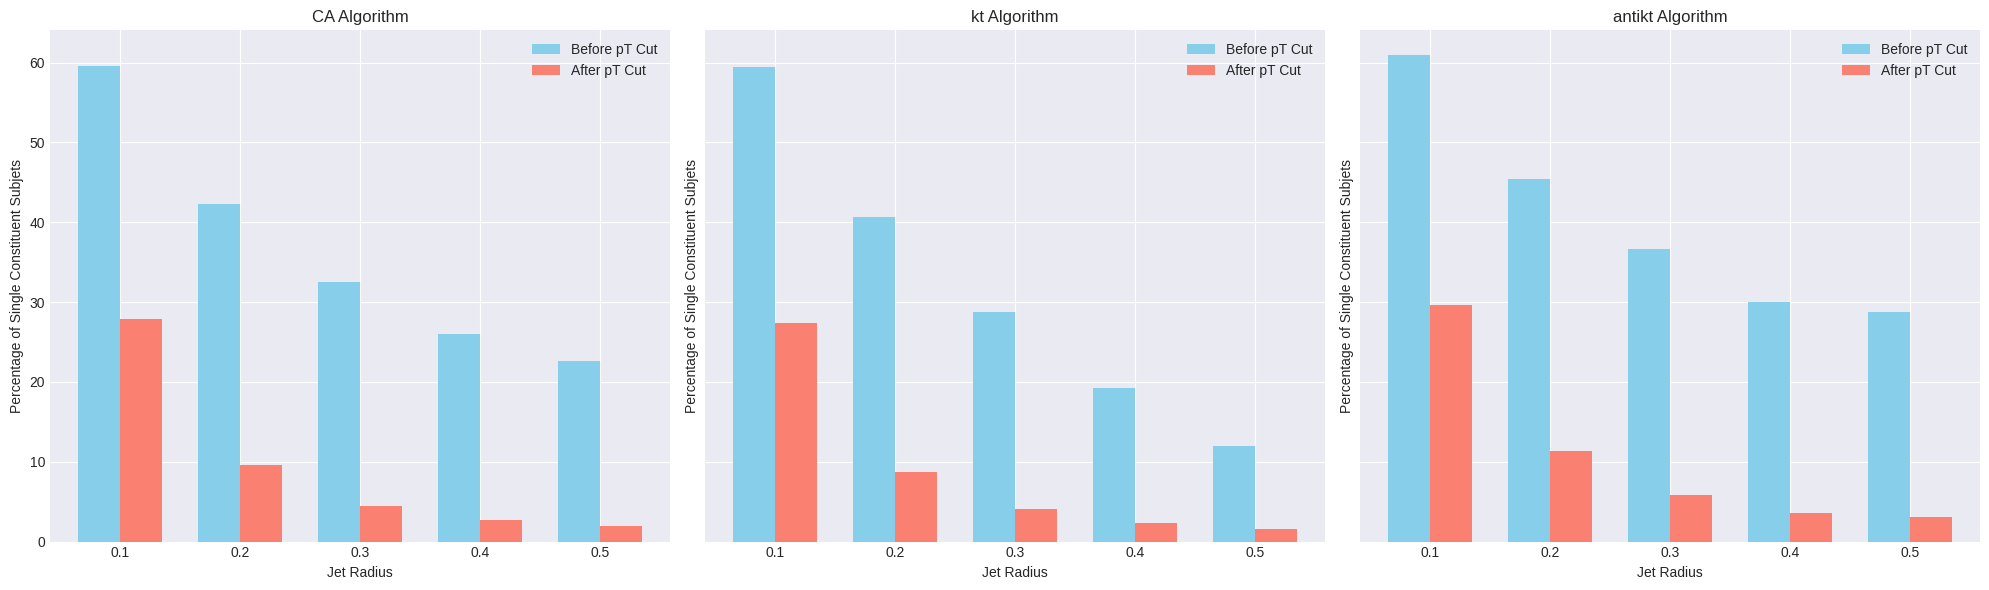

In [19]:
plt.style.use('seaborn-darkgrid')

# Create the figure with subplots
fig, axes = plt.subplots(1, len(algorithms), figsize=(20, 6), sharey=True)

# Set a larger bar width for better visibility
bar_width = 0.35
for j, alg in enumerate(algorithms):
    single_const_percentages_before = results_dict_before[alg]
    single_const_percentages_after = results_dict_after[alg]
    # Plotting percentages before and after pT cut side by side
    indices = np.arange(len(jet_radii))  # the x locations for the groups
    axes[j].bar(indices - bar_width/2, single_const_percentages_before, bar_width, color='skyblue', label='Before pT Cut')
    axes[j].bar(indices + bar_width/2, single_const_percentages_after, bar_width, color='salmon', label='After pT Cut')

    axes[j].set_title(f"{alg} Algorithm")
    axes[j].set_xlabel('Jet Radius')
    axes[j].set_xticks(indices)
    axes[j].set_xticklabels([f"{r:.1f}" for r in jet_radii])
    axes[j].set_ylabel('Percentage of Single Constituent Subjets')
    axes[j].legend()
# Adjust the layout
plt.tight_layout()
# plt.title("Percentage of single particle subjets before and after pT cut")
plt.savefig(f"{save_path}/single_particle_percent_comparison.png", bbox_inches='tight', dpi=300)
plt.show()

## Generate indices for subjets

In [118]:
def get_subjets(px, py, pz, e, JET_ALGO="CA", jet_radius=0.2):
    """
    Clusters particles into subjets using the specified jet clustering algorithm and jet radius,
    then returns information about the subjets sorted by their transverse momentum (pT) in descending order.

    Each particle is represented by its momentum components (px, py, pz) and energy (e). The function
    filters out zero-momentum particles, clusters the remaining particles into jets using the specified
    jet algorithm and radius, and then retrieves each subjet's pT, eta, and phi, along with the indices
    of the original particles that constitute each subjet.

    Parameters:
    - px (np.ndarray): NumPy array containing the x-component of momentum for each particle.
    - py (np.ndarray): NumPy array containing the y-component of momentum for each particle.
    - pz (np.ndarray): NumPy array containing the z-component of momentum for each particle.
    - e (np.ndarray): NumPy array containing the energy of each particle.
    - JET_ALGO (str, optional): The jet clustering algorithm to use. Choices are "CA" (Cambridge/Aachen), "kt", and "antikt".
      The default is "CA".
    - jet_radius (float, optional): The radius parameter for the jet clustering algorithm. The default is 0.2.

    Returns:
    - List[Dict]: A list of dictionaries, one for each subjet. Each dictionary contains two keys:
        "features", mapping to another dictionary with keys "pT", "eta", and "phi" representing the subjet's
        kinematic properties, and "indices", mapping to a list of indices corresponding to the original
        particles that make up the subjet. The list is sorted by the subjets' pT in descending order.

    Example:
    >>> px = np.array([...])
    >>> py = np.array([...])
    >>> pz = np.array([...])
    >>> e = np.array([...])
    >>> subjets_info_sorted = get_subjets(px, py, pz, e, JET_ALGO="kt", jet_radius=0.2)
    >>> print(subjets_info_sorted[0])  # Access the leading subjet information
    """

    if JET_ALGO == "kt":
        JET_ALGO = fastjet.kt_algorithm
    elif JET_ALGO == "antikt":
        JET_ALGO = fastjet.antikt_algorithm
    else:  # Default to "CA" if not "kt" or "antikt"
        JET_ALGO = fastjet.cambridge_algorithm

    jetdef = fastjet.JetDefinition(JET_ALGO, jet_radius)

    # Ensure px, py, pz, and e are filtered arrays of non-zero values
    px_nonzero = px[px != 0]
    py_nonzero = py[py != 0]
    pz_nonzero = pz[pz != 0]
    e_nonzero = e[e != 0]

    jet = ak.zip(
    {
        "px": px_nonzero,
        "py": py_nonzero,
        "pz": pz_nonzero,
        "E": e_nonzero,
    },
    with_name="MomentumArray4D",
    )

    # Create PseudoJet objects for non-zero particles
    pseudojets = []
    for i in range(len(px_nonzero)):
        particle = jet[i]
        pj = fastjet.PseudoJet(particle.px.item(), particle.py.item(), particle.pz.item(), particle.E.item())
        pj.set_user_index(i)
        pseudojets.append(pj)

    cluster = fastjet.ClusterSequence(pseudojets, jetdef)

    subjets = cluster.inclusive_jets()  # Get the jets from the clustering

    subjets_info = []  # List to store dictionaries for each subjet
    
    for subjet in subjets:
        # Extract features
        features = {
            "pT": subjet.pt(),
            "eta": subjet.eta(),
            "phi": subjet.phi(),
            "num_ptcls": 0
        }
        
        # Extract indices, sort by pT
        indices = [constituent.user_index() for constituent in subjet.constituents()]
        indices = sorted(indices)  # since the original particles were already sorted by pT
        features["num_ptcls"] = len(indices)
    
        # Create dictionary for the current subjet and append to the list
        subjet_dict = {"features": features, "indices": indices}
        subjets_info.append(subjet_dict)
    
    # subjets_info now contains the required dictionaries for each subjet
    subjets_info_sorted = sorted(subjets_info, key=lambda x: x["features"]["pT"], reverse=True)
    
    # subjets_info_sorted now contains the subjets sorted by pT in descending order
    return subjets_info_sorted


In [204]:
import numpy as np

jet_idx = 10
subjets_info_sorted = get_subjets(_px[jet_idx], _py[jet_idx], _pz[jet_idx], _e[jet_idx])

In [205]:
subjets_info_sorted

[{'features': {'pT': 274.37593487174126,
   'eta': 0.5232519289457074,
   'phi': 4.436148333003802,
   'num_ptcls': 12},
  'indices': [0, 1, 2, 7, 8, 17, 19, 23, 28, 30, 41, 46]},
 {'features': {'pT': 169.46503147984583,
   'eta': 1.1733787083266176,
   'phi': 4.218457681762092,
   'num_ptcls': 25},
  'indices': [3,
   5,
   11,
   13,
   21,
   25,
   26,
   27,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   43,
   47,
   49,
   50,
   51,
   52,
   56,
   57,
   68,
   72]},
 {'features': {'pT': 142.3950374607123,
   'eta': 0.34582926575557543,
   'phi': 4.824404430433805,
   'num_ptcls': 11},
  'indices': [4, 6, 9, 12, 14, 16, 22, 24, 29, 39, 60]},
 {'features': {'pT': 26.5798108774587,
   'eta': 0.34659859735449966,
   'phi': 5.031538428880699,
   'num_ptcls': 2},
  'indices': [10, 18]},
 {'features': {'pT': 25.8393084259638,
   'eta': 1.2703330848204522,
   'phi': 4.741602147787571,
   'num_ptcls': 6},
  'indices': [15, 20, 44, 53, 63, 71]},
 {'features': {'pT': 8.02042323909

## Zero-pad to desired dimensions

In [200]:
def zero_pad(subjets_info, n_subjets, n_ptcls_per_subjet):
    """
    Pads the subjets and their constituent particle indices to fixed sizes.

    Args:
        subjets_info (list of dicts): List of dictionaries containing subjet features and particle indices.
        n_subjets (int): Fixed number of subjets to pad to.
        n_ptcls_per_subjet (int): Fixed number of particle indices per subjet to pad to.

    Returns:
        list of dicts: The padded list of subjet information.

    Each dictionary in the input list represents a subjet and contains:
    - "features": a dictionary with keys "pT", "eta", and "phi" for subjet features.
    - "indices": a list of indices for particles constituting the subjet.
    Padded subjets will have 0 for all features and -1 for all particle indices.
    """
    # Create a deep copy of subjets_info to avoid modifying the original list
    padded_subjets_info = deepcopy(subjets_info)
    # Pad subjets to have a fixed number of subjets
    while len(padded_subjets_info) < n_subjets:
        padded_subjets_info.append({"features": {"pT": 0, "eta": 0, "phi": 0, "num_ptcls": 0}, "indices": [-1] * n_ptcls_per_subjet})

    # Pad each subjet to have a fixed number of particle indices
    for subjet in padded_subjets_info:
        subjet["indices"] += [-1] * (n_ptcls_per_subjet - len(subjet["indices"]))
        subjet["indices"] = subjet["indices"][:n_ptcls_per_subjet]  # Ensure not to exceed the fixed size if already larger
        # subjet["indices"] = np.array(subjet["indices"])

    return padded_subjets_info


In [206]:
n_subjets = 15
n_ptcls_per_subjet = 10
subjets_padded = zero_pad(subjets_info_sorted, n_subjets, n_ptcls_per_subjet)

In [207]:
subjets_padded

[{'features': {'pT': 274.37593487174126,
   'eta': 0.5232519289457074,
   'phi': 4.436148333003802,
   'num_ptcls': 12},
  'indices': [0, 1, 2, 7, 8, 17, 19, 23, 28, 30]},
 {'features': {'pT': 169.46503147984583,
   'eta': 1.1733787083266176,
   'phi': 4.218457681762092,
   'num_ptcls': 25},
  'indices': [3, 5, 11, 13, 21, 25, 26, 27, 31, 32]},
 {'features': {'pT': 142.3950374607123,
   'eta': 0.34582926575557543,
   'phi': 4.824404430433805,
   'num_ptcls': 11},
  'indices': [4, 6, 9, 12, 14, 16, 22, 24, 29, 39]},
 {'features': {'pT': 26.5798108774587,
   'eta': 0.34659859735449966,
   'phi': 5.031538428880699,
   'num_ptcls': 2},
  'indices': [10, 18, -1, -1, -1, -1, -1, -1, -1, -1]},
 {'features': {'pT': 25.8393084259638,
   'eta': 1.2703330848204522,
   'phi': 4.741602147787571,
   'num_ptcls': 6},
  'indices': [15, 20, 44, 53, 63, 71, -1, -1, -1, -1]},
 {'features': {'pT': 8.020423239091185,
   'eta': 0.836887455174039,
   'phi': 4.469839667863495,
   'num_ptcls': 5},
  'indices':

In [208]:
subjet_info_str = json.dumps(subjets_padded)

In [211]:
import h5py
import json

# Assuming 'subjets_info' is a list of dictionaries for all jets
serialized_subjets = [json.dumps(subjet) for subjet in subjets_padded]

with h5py.File('subjets_dataset.h5', 'w') as hdf:
    dtype = h5py.special_dtype(vlen=str)  # Define variable-length string data type
    dataset = hdf.create_dataset("subjets", (len(serialized_subjets),), dtype=dtype)
    for i, subjet_str in enumerate(serialized_subjets):
        dataset[i] = subjet_str  # Store each serialized subjet string


In [214]:

# Open the HDF5 file
with h5py.File('subjets_dataset.h5', 'r') as hdf:
    # Access the dataset containing your JSON strings
    dataset = hdf["subjets"]
    
    # Initialize a list to hold the deserialized subjets data
    subjets_data = []
    
    # Iterate over each JSON string in the dataset
    for json_str in dataset:
        # Deserialize the JSON string to a Python object
        subjet = json.loads(json_str)
        subjets_data.append(subjet)

# At this point, `subjets_data` contains all your subjets as Python dictionaries
subjets_data

[{'features': {'pT': 274.37593487174126,
   'eta': 0.5232519289457074,
   'phi': 4.436148333003802,
   'num_ptcls': 12},
  'indices': [0, 1, 2, 7, 8, 17, 19, 23, 28, 30]},
 {'features': {'pT': 169.46503147984583,
   'eta': 1.1733787083266176,
   'phi': 4.218457681762092,
   'num_ptcls': 25},
  'indices': [3, 5, 11, 13, 21, 25, 26, 27, 31, 32]},
 {'features': {'pT': 142.3950374607123,
   'eta': 0.34582926575557543,
   'phi': 4.824404430433805,
   'num_ptcls': 11},
  'indices': [4, 6, 9, 12, 14, 16, 22, 24, 29, 39]},
 {'features': {'pT': 26.5798108774587,
   'eta': 0.34659859735449966,
   'phi': 5.031538428880699,
   'num_ptcls': 2},
  'indices': [10, 18, -1, -1, -1, -1, -1, -1, -1, -1]},
 {'features': {'pT': 25.8393084259638,
   'eta': 1.2703330848204522,
   'phi': 4.741602147787571,
   'num_ptcls': 6},
  'indices': [15, 20, 44, 53, 63, 71, -1, -1, -1, -1]},
 {'features': {'pT': 8.020423239091185,
   'eta': 0.836887455174039,
   'phi': 4.469839667863495,
   'num_ptcls': 5},
  'indices':

## Save to h5

In [148]:
save_path = "../data"
os.system(f"mkdir -p {save_path}")  # -p: create parent dirs if needed, exist_ok

0

In [215]:
import json
import h5py
import numpy as np
import random
import tqdm

# Assuming particles_features is already prepared and has the shape (403000, 4, 128)
particles_features = features_array  # Make sure this is defined
labels_array = labels_array  # Make sure this is defined


with h5py.File(f'{save_path}/val_1%.h5', 'w') as hdf:
    # Create group for particles
    particles_group = hdf.create_group("particles")
    # Storing the particles features array directly
    particles_group.create_dataset("features", data=particles_features)
    particles_group.create_dataset("labels", data=labels_array)
    
    # Initialize an empty list to store serialized subjets information
    serialized_subjets = []
    
    # Sample 1% of the data randomly
    sample_size = int(0.01 * len(df))  # Adjusted to 1% as per initial description
    sampled_indices = random.sample(range(len(df)), sample_size)  # Get random indices

    for jet_idx in tqdm.tqdm(sampled_indices):  # Iterate over sampled indices
        subjets_info = get_subjets(_px[jet_idx], _py[jet_idx], _pz[jet_idx], _e[jet_idx])
        n_subjets = 15
        n_ptcls_per_subjet = 10
        subjets_padded = zero_pad(subjets_info_sorted, n_subjets, n_ptcls_per_subjet)
    
        # Serialize subjets_info as a JSON string and add it to the list
        serialized_subjets.append(json.dumps(subjets_padded))
    
    # Convert list of JSON strings to numpy object array for storage
    serialized_subjets_array = np.array(serialized_subjets, dtype='object')
    
    # Create a special dtype for variable-length strings
    dt = h5py.special_dtype(vlen=str)
    
    # Create dataset for serialized subjets using variable-length strings
    ds = hdf.create_dataset("subjets", data=serialized_subjets_array, dtype=dt)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4030/4030 [00:24<00:00, 166.32it/s]


In [222]:
with h5py.File(f'{save_path}/val_1%.h5', 'r') as hdf:
        # Access the dataset containing your JSON strings
    dataset = hdf["subjets"]
    
    # Initialize a list to hold the deserialized subjets data
    subjets_data = []
    particles_features = hdf["particles"]["features"][:]
    particles_labels = hdf["particles"]["labels"][:]
    
    # Iterate over each JSON string in the dataset
    for json_str in dataset:
        # Deserialize the JSON string to a Python object
        subjet = json.loads(json_str)
        subjets_data.append(subjet)

# At this point, `subjets_data` contains all your subjets as Python dictionaries

In [225]:
particles_labels.shape

(403000,)

In [226]:
len(subjets_data)

4030

In [203]:
import json
import h5py
import numpy as np

# Assuming particles_features is already prepared and has the shape (403000, 4, 128)
particles_features = features_array

with h5py.File(f'{save_path}/val_1%.h5', 'w') as hdf:
    # Create group for particles
    particles_group = hdf.create_group("particles")
    # Storing the particles features array directly
    particles_group.create_dataset("features", data=particles_features)
    particles_group.create_dataset("labels", data=labels_array)
    
    # Example loop over the dataset for subjets (adjust according to your data and requirements)
    subjets = []
    # Sample 10% of the data randomly
    sample_size = int(0.001 * len(df))  # Calculate 1% of your dataset size
    sampled_indices = random.sample(range(len(df)), sample_size)  # Get random indices

    for jet_idx in tqdm.tqdm(sampled_indices):  # Iterate over sampled indices
        subjet_info = get_subjets(_px[jet_idx], _py[jet_idx], _pz[jet_idx], _e[jet_idx])
        n_subjets = 15
        n_ptcls_per_subjet = 10
        subjets_padded = zero_pad(subjets_info_sorted, n_subjets, n_ptcls_per_subjet)
    
        # Serialize subjets_info as a JSON string
        # subjet_info_str = json.dumps(subjets_padded)
        # subjets.append(np.array(subjets_info_str, dtype='S'))
        subjets.append(subjets_padded)
        # Store the serialized string in the HDF5 file (as an attribute or a dataset)
        # Since HDF5 attributes have size limits, you might prefer using datasets for large data
    ds = hdf.create_dataset(f"subjets", data=subjets)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403/403 [00:02<00:00, 167.05it/s]


TypeError: Object dtype dtype('O') has no native HDF5 equivalent

In [202]:
subjets

[array(b'[{"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features

In [187]:
import h5py
import json
import numpy as np

# Open the HDF5 file in read mode
with h5py.File(f'{save_path}/val_1%.h5', 'r') as hdf:
    print(hdf.keys())
    # Access the 'subjets' and 'particles' groups
    # particles_group = hdf['particles']
    # print(particles_group.keys())
    # # Access the 'features' dataset within the 'particles' group
    # if "features" in particles_group:
    #     particles_features = particles_group["features"][:]
    #     print(f"Shape of the particles features tensor: {particles_features.shape}")
    # else:
    #     print("Particles features dataset not found.")
    print(hdf['particles']['features'][0].shape)
    subjets_from_file = hdf['subjets']
    print(subjets_from_file[:-10])
    # print(len(hdf['subjets']))


<KeysViewHDF5 ['particles', 'subjets']>
(4, 128)
[b'[{"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]}, {"features": {"pT": 0, "eta": 0, "phi": 0}, "indices": [-1, -1, -

<Closed HDF5 dataset>

non zero constituents of jet 0: 20
Jet 0 has 1 constituents.
Jet 1 has 1 constituents.
Jet 2 has 1 constituents.
Jet 3 has 1 constituents.
Jet 4 has 1 constituents.
Jet 5 has 15 constituents.


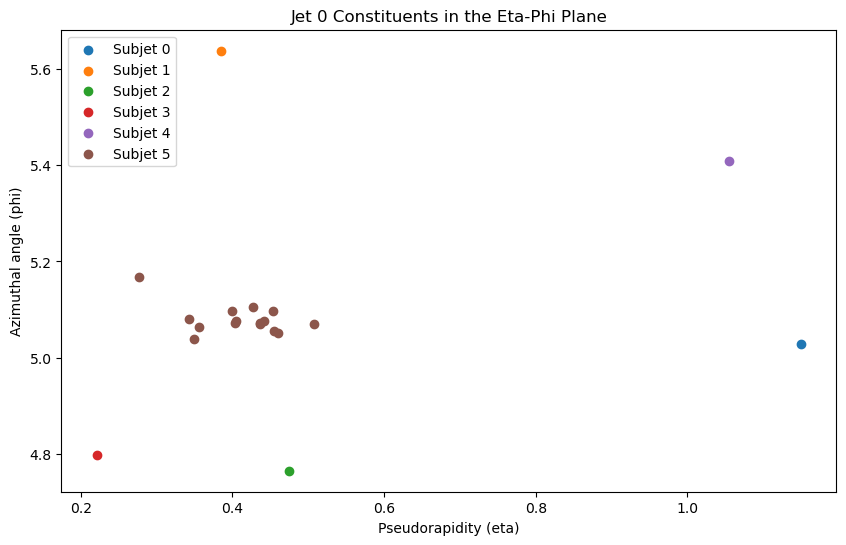

non zero constituents of jet 1: 41
Jet 0 has 4 constituents.
Jet 1 has 2 constituents.
Jet 2 has 1 constituents.
Jet 3 has 18 constituents.
Jet 4 has 1 constituents.
Jet 5 has 1 constituents.
Jet 6 has 14 constituents.


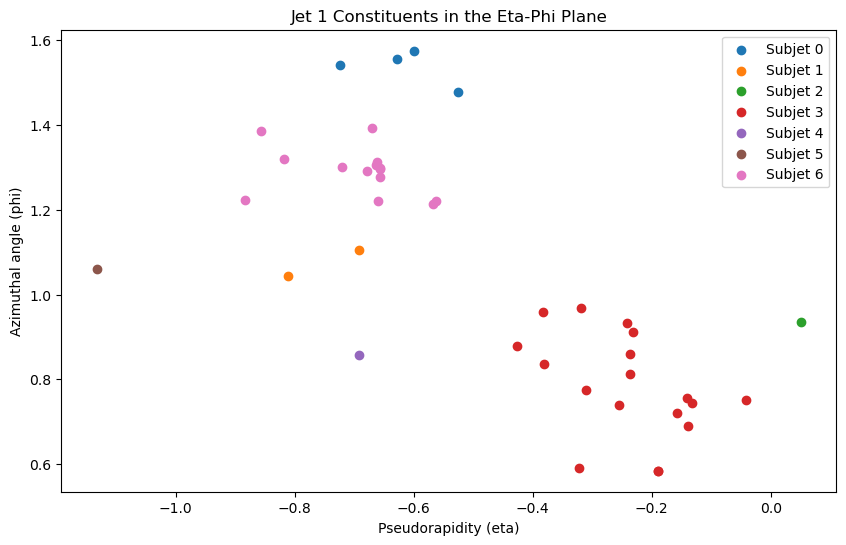

non zero constituents of jet 2: 43
Jet 0 has 25 constituents.
Jet 1 has 1 constituents.
Jet 2 has 2 constituents.
Jet 3 has 2 constituents.
Jet 4 has 1 constituents.
Jet 5 has 2 constituents.
Jet 6 has 1 constituents.
Jet 7 has 1 constituents.
Jet 8 has 2 constituents.
Jet 9 has 6 constituents.


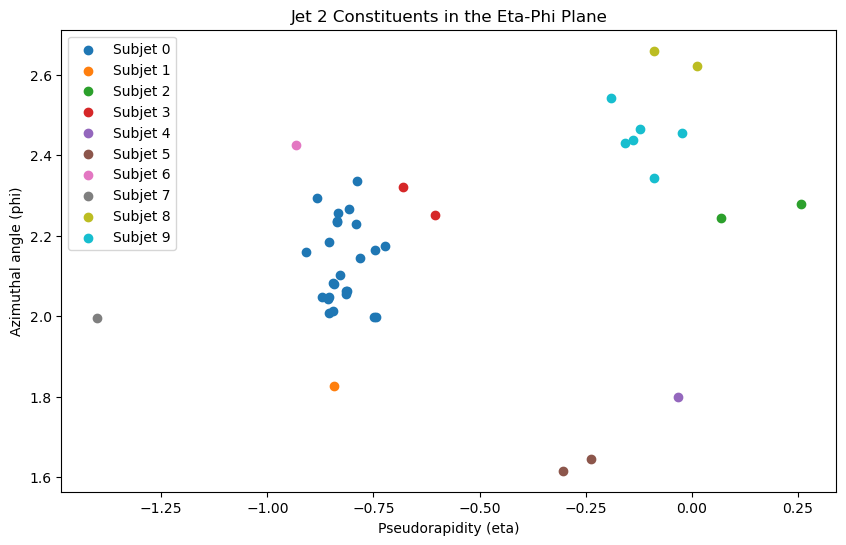

non zero constituents of jet 3: 71
Jet 0 has 1 constituents.
Jet 1 has 2 constituents.
Jet 2 has 1 constituents.
Jet 3 has 3 constituents.
Jet 4 has 3 constituents.
Jet 5 has 22 constituents.
Jet 6 has 1 constituents.
Jet 7 has 1 constituents.
Jet 8 has 2 constituents.
Jet 9 has 1 constituents.
Jet 10 has 2 constituents.
Jet 11 has 2 constituents.
Jet 12 has 1 constituents.
Jet 13 has 1 constituents.
Jet 14 has 28 constituents.


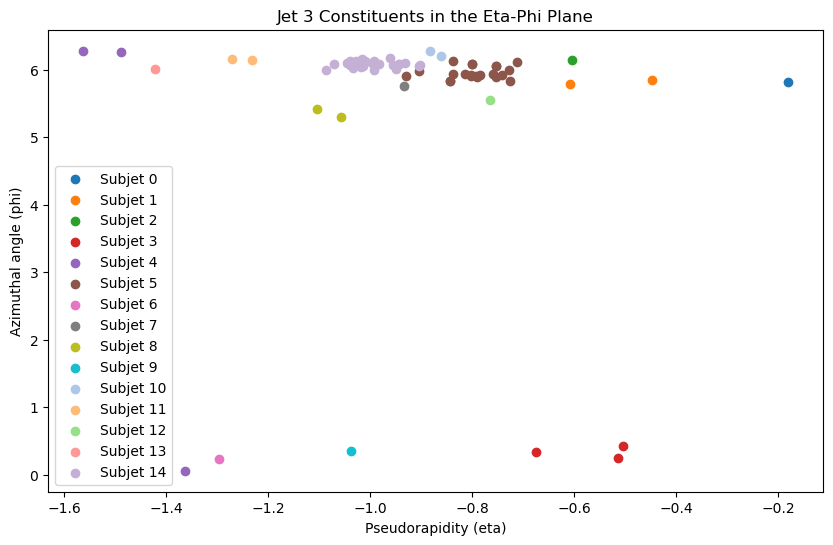

non zero constituents of jet 4: 19
Jet 0 has 2 constituents.
Jet 1 has 17 constituents.


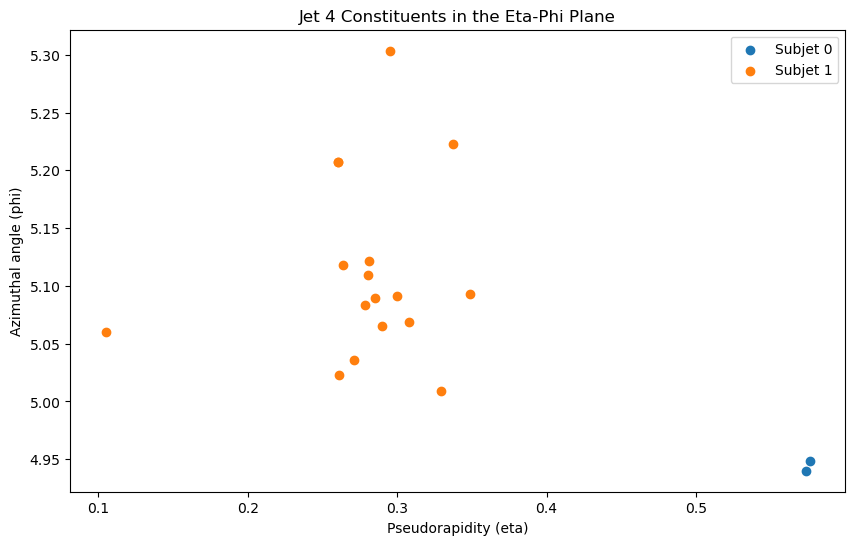

non zero constituents of jet 5: 30
Jet 0 has 10 constituents.
Jet 1 has 1 constituents.
Jet 2 has 3 constituents.
Jet 3 has 5 constituents.
Jet 4 has 2 constituents.
Jet 5 has 1 constituents.
Jet 6 has 8 constituents.


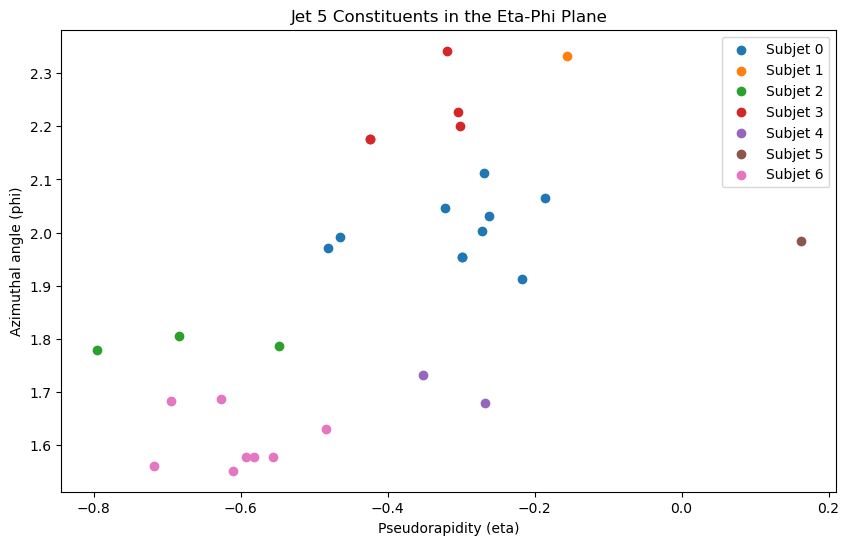

non zero constituents of jet 6: 53
Jet 0 has 1 constituents.
Jet 1 has 1 constituents.
Jet 2 has 16 constituents.
Jet 3 has 1 constituents.
Jet 4 has 1 constituents.
Jet 5 has 1 constituents.
Jet 6 has 1 constituents.
Jet 7 has 1 constituents.
Jet 8 has 1 constituents.
Jet 9 has 2 constituents.
Jet 10 has 2 constituents.
Jet 11 has 5 constituents.
Jet 12 has 20 constituents.


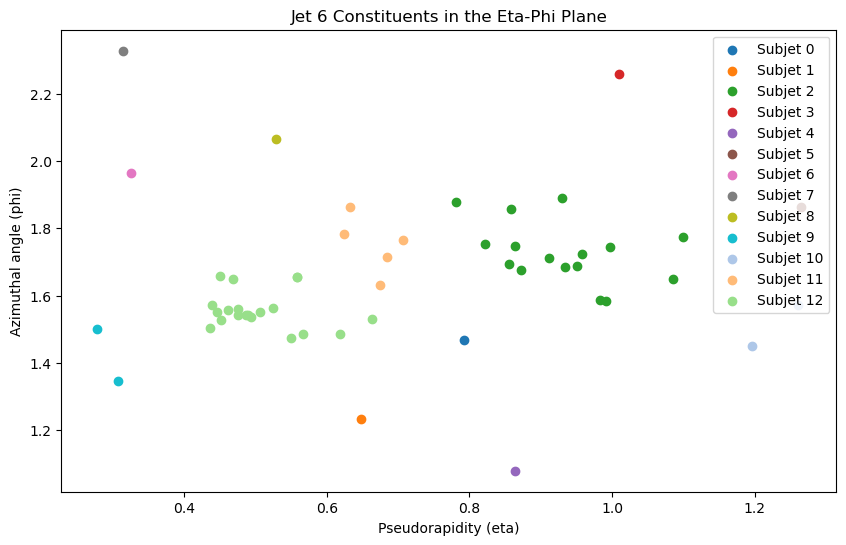

non zero constituents of jet 7: 26
Jet 0 has 2 constituents.
Jet 1 has 1 constituents.
Jet 2 has 3 constituents.
Jet 3 has 3 constituents.
Jet 4 has 17 constituents.


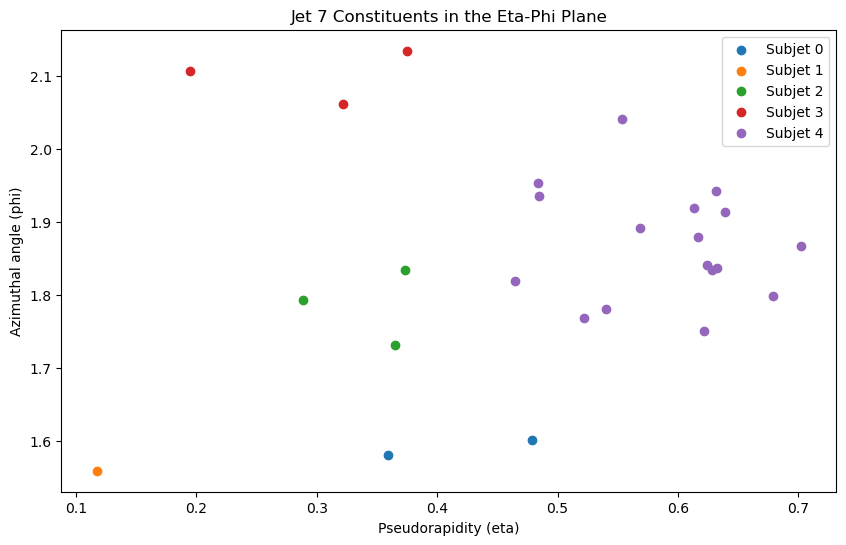

non zero constituents of jet 8: 33
Jet 0 has 11 constituents.
Jet 1 has 1 constituents.
Jet 2 has 1 constituents.
Jet 3 has 1 constituents.
Jet 4 has 1 constituents.
Jet 5 has 2 constituents.
Jet 6 has 16 constituents.


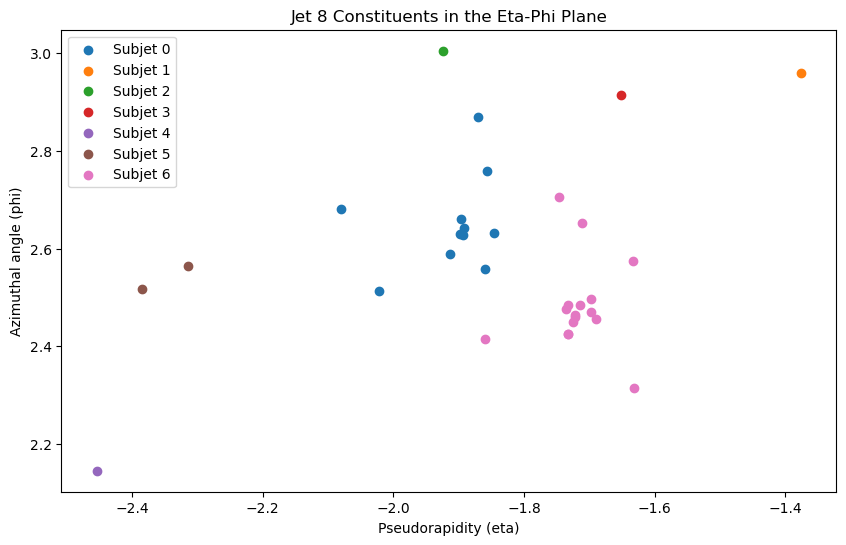

non zero constituents of jet 9: 92
Jet 0 has 1 constituents.
Jet 1 has 7 constituents.
Jet 2 has 2 constituents.
Jet 3 has 1 constituents.
Jet 4 has 10 constituents.
Jet 5 has 2 constituents.
Jet 6 has 2 constituents.
Jet 7 has 4 constituents.
Jet 8 has 2 constituents.
Jet 9 has 5 constituents.
Jet 10 has 3 constituents.
Jet 11 has 1 constituents.
Jet 12 has 5 constituents.
Jet 13 has 2 constituents.
Jet 14 has 6 constituents.
Jet 15 has 1 constituents.
Jet 16 has 38 constituents.


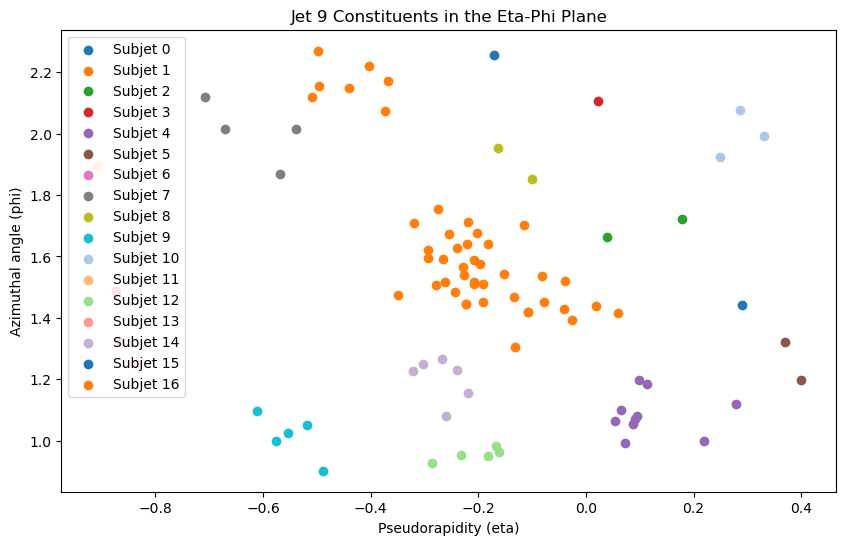

In [73]:
for idx in range(10):
    print(f"non zero constituents of jet {idx}: {np.count_nonzero(_px[idx])}")
    cluster = get_subjets(_px[idx][_px[idx] != 0], _py[idx][_py[idx] != 0], _pz[idx][_pz[idx] != 0], _e[idx][_e[idx] != 0], JET_ALGO="CA")
    jets = cluster.inclusive_jets()
    for i, jet in enumerate(jets):
        constituents = jet.constituents()
        print(f"Jet {i} has {len(constituents)} constituents.")
    # Assuming 'jets' is a list of jets you obtained from the cluster
    # And 'cluster' is still in scope

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Define colors for each subjet
    colors = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf',  # blue-teal
        '#aec7e8',  # light blue
        '#ffbb78',  # sandy orange
        '#98df8a',  # pea green
        '#ff9896',  # pale pink
        '#c5b0d5',  # light purple
    ]

    subjet_labels = set()  # Keep track of which subjet labels have been used

    for jet_idx, jet in enumerate(jets):
        # Get constituents for each jet
        constituents = jet.constituents()

        # Calculate eta and phi for each constituent and plot them
        for particle in constituents:
            eta = particle.eta()
            phi = particle.phi()

            # Assign a color based on the subjet index
            # This example assumes each constituent is assigned a subjet index somehow
            # Replace 'subjet_index' with your actual logic for subjet identification
            subjet_index = jet_idx  # Placeholder for actual subjet index
            color = colors[subjet_index % len(colors)]

            # Create a label only if we haven't already created one for this subjet
            label = f'Subjet {subjet_index}' if subjet_index not in subjet_labels else None

            # Add the label to the set so it doesn't get used again
            if label:
                subjet_labels.add(subjet_index)

            # Plot the eta-phi point
            plt.scatter(eta, phi, color=color, label=label)

    # Add labels and legend
    plt.xlabel('Pseudorapidity (eta)')
    plt.ylabel('Azimuthal angle (phi)')
    plt.title(f'Jet {idx} Constituents in the Eta-Phi Plane')
    plt.legend()
    plt.savefig(f"{save_path}/Jet{idx}", bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()


In [67]:
!pwd

/ssl-jet-vol-v2/I-JEPA-Jets/notebooks


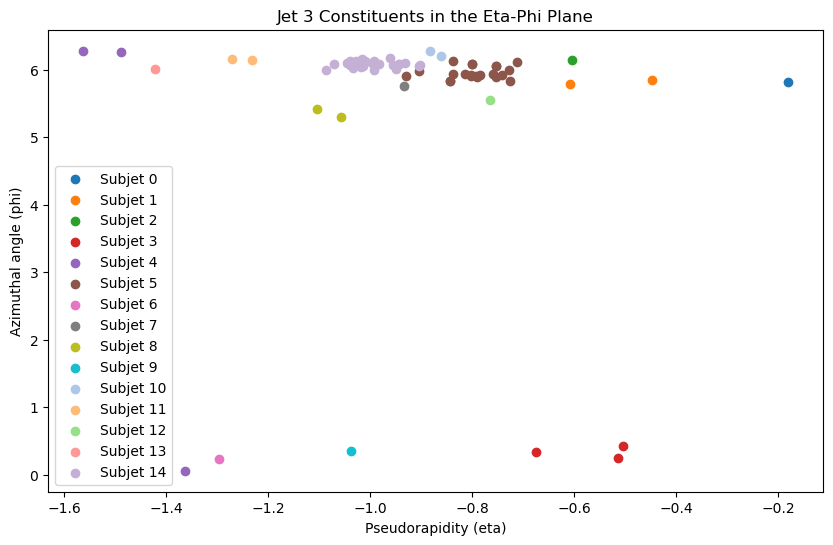

In [71]:
# Assuming 'jets' is a list of jets you obtained from the cluster
# And 'cluster' is still in scope

# Create a plot
plt.figure(figsize=(10, 6))

# Define colors for each subjet
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf',  # blue-teal
    '#aec7e8',  # light blue
    '#ffbb78',  # sandy orange
    '#98df8a',  # pea green
    '#ff9896',  # pale pink
    '#c5b0d5',  # light purple
]

subjet_labels = set()  # Keep track of which subjet labels have been used

for jet_idx, jet in enumerate(jets):
    # Get constituents for each jet
    constituents = jet.constituents()
    
    # Calculate eta and phi for each constituent and plot them
    for particle in constituents:
        eta = particle.eta()
        phi = particle.phi()
        
        # Assign a color based on the subjet index
        # This example assumes each constituent is assigned a subjet index somehow
        # Replace 'subjet_index' with your actual logic for subjet identification
        subjet_index = jet_idx  # Placeholder for actual subjet index
        color = colors[subjet_index % len(colors)]
        
        # Create a label only if we haven't already created one for this subjet
        label = f'Subjet {subjet_index}' if subjet_index not in subjet_labels else None
        
        # Add the label to the set so it doesn't get used again
        if label:
            subjet_labels.add(subjet_index)
        
        # Plot the eta-phi point
        plt.scatter(eta, phi, color=color, label=label)

# Add labels and legend
plt.xlabel('Pseudorapidity (eta)')
plt.ylabel('Azimuthal angle (phi)')
plt.title(f'Jet {idx} Constituents in the Eta-Phi Plane')
plt.legend()
plt.savefig(f"{save_path}/Jet{idx}", bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


non zero constituents of jet 9: 92


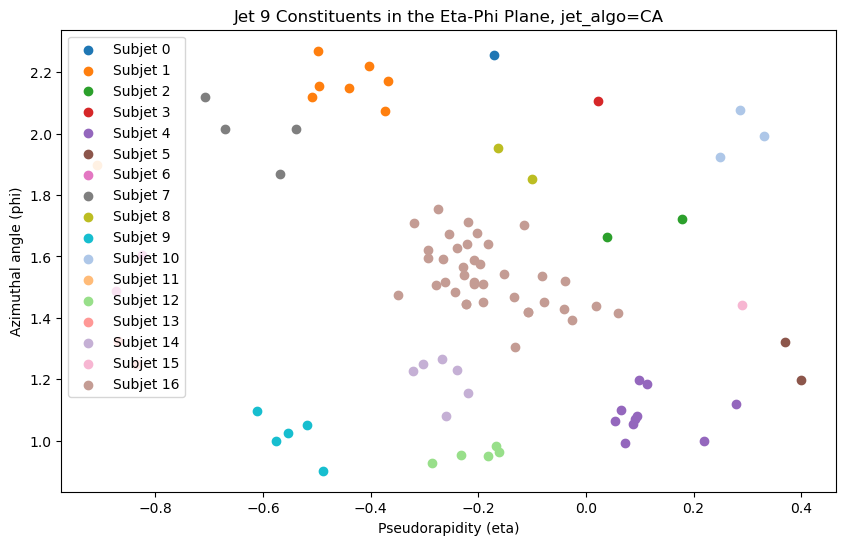

non zero constituents of jet 9: 92


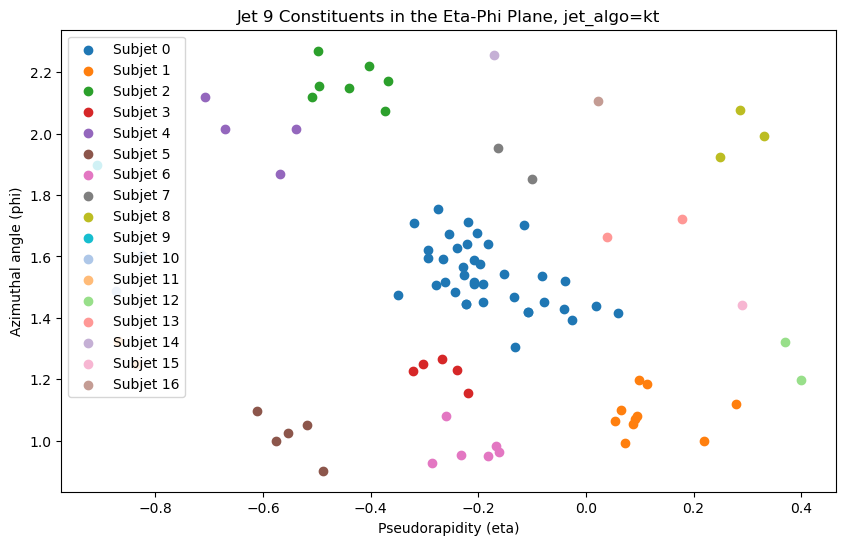

non zero constituents of jet 9: 92


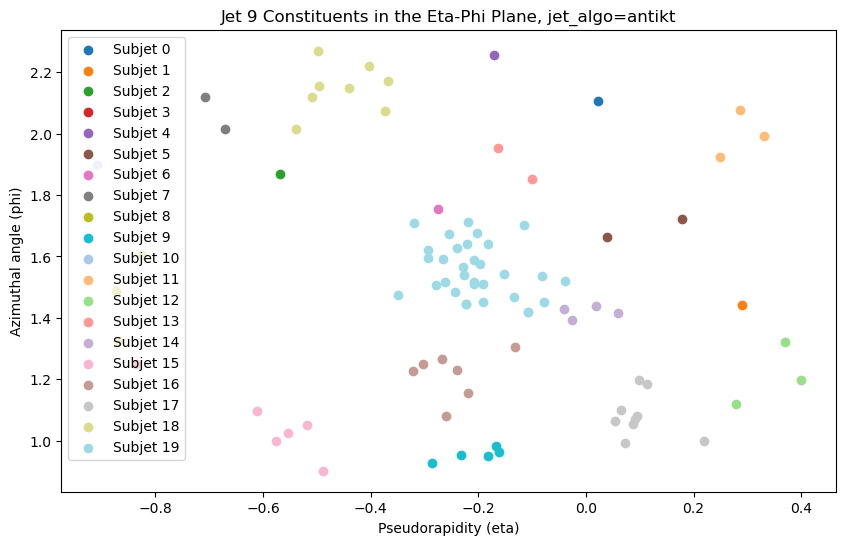

In [75]:
idx = 9
for algo in ["CA", "kt", "antikt"]:
    print(f"non zero constituents of jet {idx}: {np.count_nonzero(_px[idx])}")
    cluster = get_subjets(_px[idx][_px[idx] != 0], _py[idx][_py[idx] != 0], _pz[idx][_pz[idx] != 0], _e[idx][_e[idx] != 0], JET_ALGO=algo)
    jets = cluster.inclusive_jets()
    # Assuming 'jets' is a list of jets you obtained from the cluster
    # And 'cluster' is still in scope

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Define colors for each subjet
    colors = [
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf',  # blue-teal
        '#aec7e8',  # light blue
        '#ffbb78',  # sandy orange
        '#98df8a',  # pea green
        '#ff9896',  # pale pink
        '#c5b0d5',  # light purple
        '#f7b6d2',  # soft pink
        '#c49c94',  # rosy brown
        '#c7c7c7',  # silver gray
        '#dbdb8d',  # olive green
        '#9edae5'  # soft blue
    ]

    subjet_labels = set()  # Keep track of which subjet labels have been used

    for jet_idx, jet in enumerate(jets):
        # Get constituents for each jet
        constituents = jet.constituents()

        # Calculate eta and phi for each constituent and plot them
        for particle in constituents:
            eta = particle.eta()
            phi = particle.phi()

            # Assign a color based on the subjet index
            # This example assumes each constituent is assigned a subjet index somehow
            # Replace 'subjet_index' with your actual logic for subjet identification
            subjet_index = jet_idx  # Placeholder for actual subjet index
            color = colors[subjet_index % len(colors)]

            # Create a label only if we haven't already created one for this subjet
            label = f'Subjet {subjet_index}' if subjet_index not in subjet_labels else None

            # Add the label to the set so it doesn't get used again
            if label:
                subjet_labels.add(subjet_index)

            # Plot the eta-phi point
            plt.scatter(eta, phi, color=color, label=label)

    # Add labels and legend
    plt.xlabel('Pseudorapidity (eta)')
    plt.ylabel('Azimuthal angle (phi)')
    plt.title(f'Jet {idx} Constituents in the Eta-Phi Plane, jet_algo={algo}')
    plt.legend()
    plt.savefig(f"{save_path}/Jet{idx}_{algo}", bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()


In [58]:
for i in range(len(res)):
    jet = res[i]
    print(f"jet {i}: ")
    print(f"pt: {jet.pt()}")
    print(f"eta: {jet.eta()}")
    print(f"phi: {jet.phi()}")
    print("--------")

jet 0: 
pt: 0.22613694970836418
eta: -0.18042667605589355
phi: 5.818748904675969
--------
jet 1: 
pt: 1.2386671401289242
eta: -0.5554740360970257
phi: 5.811575074542736
--------
jet 2: 
pt: 0.7345151456194258
eta: -0.6033621257706017
phi: 6.147729490967903
--------
jet 3: 
pt: 3.4620961419059264
eta: -0.5306572449342656
phi: 0.3055280546502352
--------
jet 4: 
pt: 2.6848779408442054
eta: -1.4289550096294068
phi: 0.026358636003473695
--------
jet 5: 
pt: 190.06135908103542
eta: -0.7851878439592209
phi: 5.969429105116184
--------
jet 6: 
pt: 0.87319112898898
eta: -1.296356931011077
phi: 0.224515159117908
--------
jet 7: 
pt: 1.2542661050459742
eta: -0.9325395312207285
phi: 5.762621307790479
--------
jet 8: 
pt: 2.48393238990201
eta: -1.0716943019946517
phi: 5.328319537723802
--------
jet 9: 
pt: 0.6029112288215416
eta: -1.0364499046941162
phi: 0.34951545410608265
--------
jet 10: 
pt: 4.558674847505307
eta: -0.8813645857423023
phi: 6.274319093787844
--------
jet 11: 
pt: 1.85327016431638